In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          DataCollatorWithPadding,
                          Trainer, TrainingArguments)
# from torch.utils.data import Dataset, DataLoader
from datasets import Dataset
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report)
from src.utils.custom_trainer import CustomTrainer

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Фиксируем random seed

In [2]:
# фиксируем рандомный сид
seed  = 20
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = False

In [3]:
# детектируем девайс
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Задание констант

In [4]:
classes_list = ["Algebra", "Geometry and Trigonometry", "Calculus and Analysis",
                "Probability and Statistics", "Number Theory", "Combinatorics and Discrete Math",
                "Linear Algebra", "Abstract Algebra and Topology"]
n_classes = len(classes_list)

train_csv_file = './data/train.csv'

batch_size = 8
num_epoches = 3

class_weights=torch.tensor([0.4903152069297401, 
                            0.5230364476386037, 
                            1.2290410132689988, 
                            3.4655612244897958, 
                            0.7324766355140186, 
                            0.6964285714285714, 
                            13.40625, 
                            14.151041666666666])

model_name = 'google-bert/bert-base-uncased'

# Извлечение данных

In [5]:
df = pd.read_csv(train_csv_file)
df = df.rename(columns={'Question': 'text'})

train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Исследование данных

Classes conts on train: [2078. 1948.  829.  294. 1391. 1463.   76.   72.]
Class diff counts: [   0.  130. 1249. 1784.  687.  615. 2002. 2006.]
Class weights: [0.4903152069297401, 0.5230364476386037, 1.2290410132689988, 3.4655612244897958, 0.7324766355140186, 0.6964285714285714, 13.40625, 14.151041666666666]


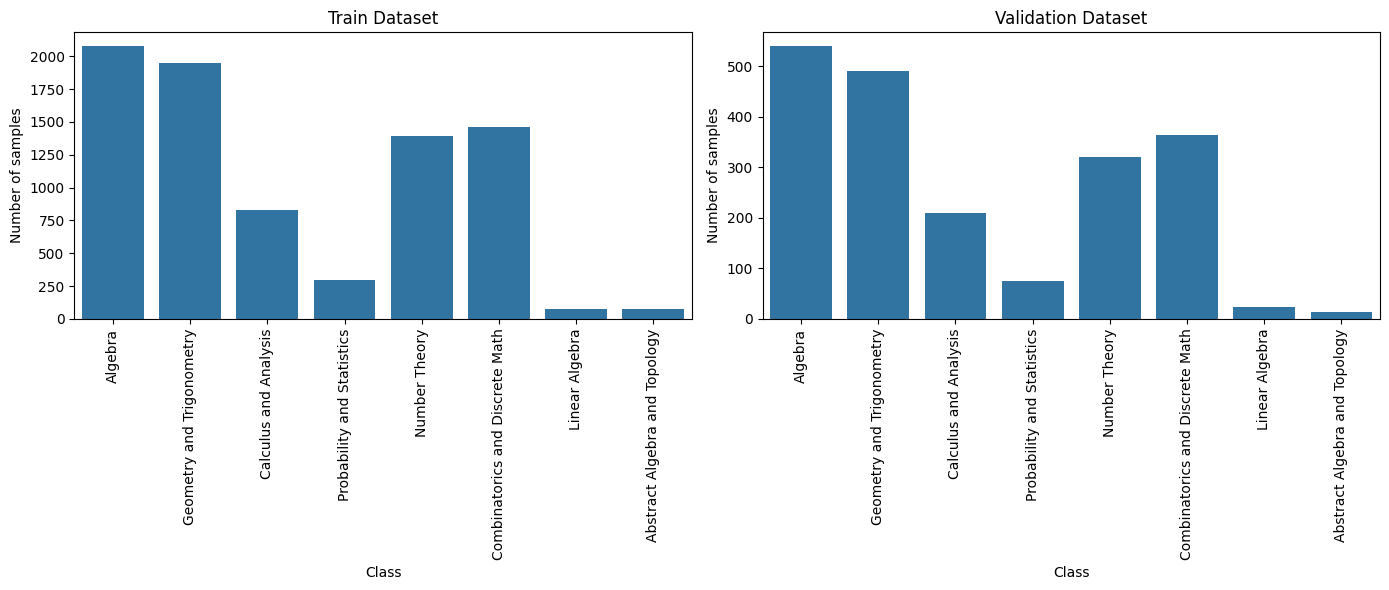

In [6]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(n_classes)
for idx, row in train_df.iterrows():
    label = row['label']
    train_class_counts[label] += 1
    
print(f"Classes conts on train: {train_class_counts}")
print(f"Class diff counts: {np.max(train_class_counts) - train_class_counts}")

# Подсчитать количество изображений в каждом классе для валидационного набора данных
val_class_counts = np.zeros(n_classes)
for idx, row in val_df.iterrows():
    label = row['label']
    val_class_counts[label] += 1

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (n_classes * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights)

# Создать barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Barplot для обучающего набора данных
sns.barplot(x=classes_list, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of samples')
ax[0].tick_params(axis='x', rotation=90)

# Barplot для валидационного набора данных
sns.barplot(x=classes_list, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of samples')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

## Add generated data

In [7]:
generated_df = pd.read_csv('./data/generated/generated_train.csv')
generated_df = generated_df.rename(columns={'Question': 'text'})

train_df = pd.concat([train_df, generated_df], ignore_index=True)

Classes conts on train: [2078. 1948. 1601. 1983. 1391. 1463. 1613. 1084.]
Class weights: [0.7916867179980751, 0.8445200205338809, 1.0275608994378513, 0.8296142208774584, 1.1826923076923077, 1.1244873547505125, 1.0199163050216986, 1.5176429889298892]


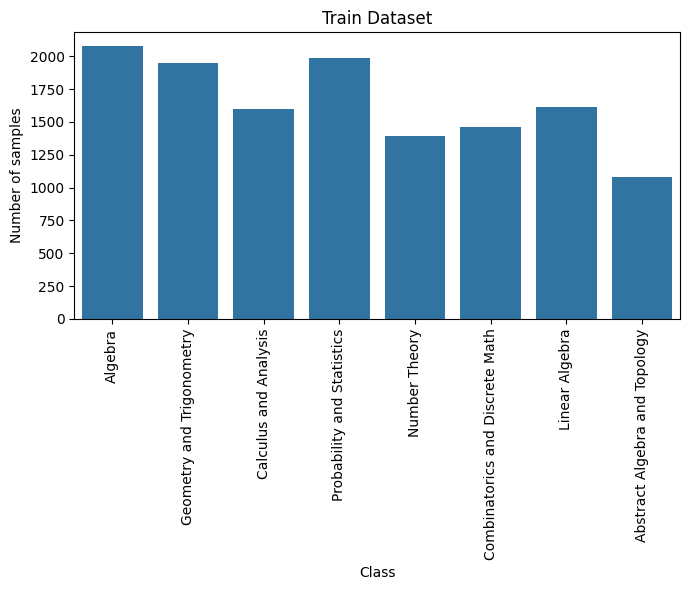

In [19]:
# Подсчитать количество изображений в каждом классе для обучающего набора данных
train_class_counts = np.zeros(n_classes)
for idx, row in train_df.iterrows():
    label = row['label']
    train_class_counts[label] += 1
    
print(f"Classes conts on train: {train_class_counts}")

# посчитаем веса для каждого класса
class_weights = (sum(train_class_counts.tolist()) / (n_classes * train_class_counts)).tolist()
print(f"Class weights: {class_weights}")
class_weights = torch.tensor(class_weights)

# Создать barplot
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

# Barplot для обучающего набора данных
sns.barplot(x=classes_list, y=train_class_counts)
ax.set_title('Train Dataset')
ax.set_xlabel('Class')
ax.set_ylabel('Number of samples')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# Импортируем модель

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=n_classes)
tokenizer = AutoTokenizer.from_pretrained(model_name)
data_collator = DataCollatorWithPadding(tokenizer) #? нужен для чего

model.to(device)

/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# Формируем datasets и dataloaders

Для обучения с помощью Trainer API нам ну нужно вручную создавать dataset, dataloader и т д. Все за нас может сделать hugging face API, нам надо только
создать подходящие по формату датасеты. Но оставим пока этот код здесь, в будущем попробуем написать ручной пайплайн обучения.

In [10]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)

In [11]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)

In [12]:
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 2038/2038 [00:00<00:00, 11306.99 examples/s]


# Baseline модель

In [13]:
def evaleate_model(model, trainer, tokenized_val_dataset, device):
    model.to(device)
    model.eval()
    predictions = trainer.predict(tokenized_val_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    true_lables = tokenized_val_dataset['label']
    cm = confusion_matrix(true_lables, preds)
    report = classification_report(true_lables, preds)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    # Вычисление взвешенной F1-меры для текущей модели
    # micro_f1 = f1_score(true_lables, preds, average='mocro')
    return (
        cm, 
        report, 
        accuracy, 
        # micro_f1,
    )

In [14]:
def plot_confusion_matrix(cm, classes, model_name=None, save_file_path=None):
    """
    Plots a confusion matrix for visualizing classification performance.

    This function takes the confusion matrix and class labels to create a heatmap
    visualization. It also allows saving the plot to a file or returning it
    without saving.

    Args:
        cm (numpy.ndarray): The confusion matrix array.
        classes (list): List of class names used in the model.
        model_name (string, optional): Name of the model for naming purposes. If None,
                                        does not set a title. Defaults to None.
        save_file_path (str, optional): Path where the plot should be saved. If None,
                                         the plot is displayed but not saved. Defaults to None.

    Returns:
        str: The filename or None if no saving occurs.

    Raises:
        AssertionError: If model_name is provided but save_file_path is not set.
    """
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        if model_name:
            assert save_file_path is not None
            plt.title(f"Confusion Matrix for {model_name}")
        else:
            plt.title("Confusion Matrix")
        
        if save_file_path is None:
            plt.show()
        else:
            # Verify that model_name exists before saving
            assert model_name, "model_name must be provided when save_file_path is not None"
            plt.savefig(f"{save_file_path}/confusion_matrix_{model_name}.jpg")
            return f"{save_file_path}/confusion_matrix_{model_name}.jpg"

100%|██████████| 255/255 [00:14<00:00, 17.34it/s]

Metrics for current model:
Test accuracy: 0.0270
              precision    recall  f1-score   support

           0       0.88      0.06      0.10       540
           1       0.00      0.00      0.00       491
           2       0.00      0.00      0.00       210
           3       0.00      0.00      0.00        74
           4       0.38      0.01      0.02       321
           5       0.00      0.00      0.00       364
           6       0.01      0.92      0.02        24
           7       0.00      0.00      0.00        14

    accuracy                           0.03      2038
   macro avg       0.16      0.12      0.02      2038
weighted avg       0.29      0.03      0.03      2038




/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/psvel/Projects/Study/SBT-kaggle-NLP/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

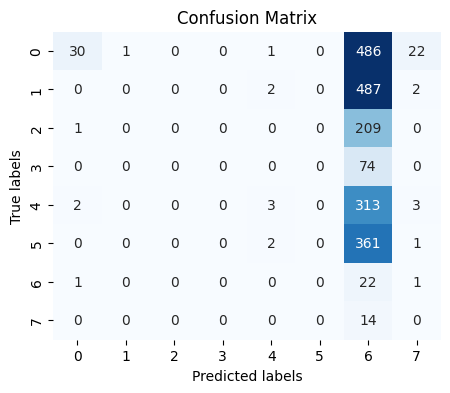

In [15]:
baseline_trainer = Trainer(
    model=model,
    eval_dataset=tokenized_val_dataset,
)

# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, baseline_trainer, tokenized_val_dataset, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))

# Тренировка модели

In [16]:
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    validation_accuracy = accuracy_score(predictions, labels)
    validation_precision = precision_score(predictions, labels)
    validation_recall = recall_score(predictions, labels)
    # validation_f1_micro = f1_score(predictions, labels, average='micro')
    # validation_f1_macro = f1_score(predictions, labels, average='macro')

    return {
        'accuracy': validation_accuracy,
        'precision': validation_precision,
        'recall': validation_recall,
        # 'f1_micro': validation_f1_micro,
        # 'f1_macro': validation_f1_macro
    }

In [17]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="steps",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epoches,
    weight_decay=0.01,
    logging_dir='./logs',  
    save_steps=1000, # сохранение чекпоинтов модели каждые 1000 шагов# директория для логов TensorBoard
    logging_steps=10
)

In [20]:

#! bug: there are some troubles with using compute_metrics function: 
#! Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    # compute_metrics=compute_metrics,
    class_weights=class_weights.to(device)
)

In [21]:
trainer.train()

                                                     
 66%|██████▌   | 3271/4938 [1:32:10<2:13:39,  4.81s/it]

{'eval_loss': 0.6908056139945984, 'eval_runtime': 14.9151, 'eval_samples_per_second': 136.64, 'eval_steps_per_second': 17.097, 'epoch': 1.99}


 66%|██████▋   | 3280/4938 [1:32:11<10:41,  2.58it/s]  

{'loss': 0.4779, 'grad_norm': 10.792753219604492, 'learning_rate': 1.6788173349534226e-05, 'epoch': 1.99}


                                                     
 66%|██████▋   | 3281/4938 [1:32:26<2:12:47,  4.81s/it]

{'eval_loss': 0.6989348530769348, 'eval_runtime': 14.9092, 'eval_samples_per_second': 136.694, 'eval_steps_per_second': 17.103, 'epoch': 1.99}


 67%|██████▋   | 3290/4938 [1:32:28<10:31,  2.61it/s]  

{'loss': 0.1975, 'grad_norm': 1.3720093965530396, 'learning_rate': 1.6686917780477927e-05, 'epoch': 2.0}


                                                     
 67%|██████▋   | 3291/4938 [1:32:43<2:11:58,  4.81s/it]

{'eval_loss': 0.6894328594207764, 'eval_runtime': 14.9147, 'eval_samples_per_second': 136.644, 'eval_steps_per_second': 17.097, 'epoch': 2.0}


 67%|██████▋   | 3300/4938 [1:32:45<12:25,  2.20it/s]  

{'loss': 0.0308, 'grad_norm': 0.9739187955856323, 'learning_rate': 1.6585662211421628e-05, 'epoch': 2.0}


                                                     
 67%|██████▋   | 3301/4938 [1:33:00<2:10:29,  4.78s/it]

{'eval_loss': 0.7355256080627441, 'eval_runtime': 14.9168, 'eval_samples_per_second': 136.625, 'eval_steps_per_second': 17.095, 'epoch': 2.0}


 67%|██████▋   | 3310/4938 [1:33:02<10:36,  2.56it/s]  

{'loss': 0.105, 'grad_norm': 1.9516664743423462, 'learning_rate': 1.648440664236533e-05, 'epoch': 2.01}


                                                     
 67%|██████▋   | 3311/4938 [1:33:17<2:10:24,  4.81s/it]

{'eval_loss': 0.7477559447288513, 'eval_runtime': 14.9118, 'eval_samples_per_second': 136.67, 'eval_steps_per_second': 17.101, 'epoch': 2.01}


 67%|██████▋   | 3320/4938 [1:33:19<10:25,  2.59it/s]  

{'loss': 0.3142, 'grad_norm': 21.00429916381836, 'learning_rate': 1.6383151073309033e-05, 'epoch': 2.02}


                                                     
 67%|██████▋   | 3321/4938 [1:33:34<2:09:41,  4.81s/it]

{'eval_loss': 0.7638322710990906, 'eval_runtime': 14.9251, 'eval_samples_per_second': 136.549, 'eval_steps_per_second': 17.085, 'epoch': 2.02}


 67%|██████▋   | 3330/4938 [1:33:36<10:27,  2.56it/s]  

{'loss': 0.1579, 'grad_norm': 25.25205421447754, 'learning_rate': 1.6281895504252734e-05, 'epoch': 2.02}


                                                     
 67%|██████▋   | 3331/4938 [1:33:51<2:08:56,  4.81s/it]

{'eval_loss': 0.7492775321006775, 'eval_runtime': 14.9214, 'eval_samples_per_second': 136.583, 'eval_steps_per_second': 17.09, 'epoch': 2.02}


 68%|██████▊   | 3340/4938 [1:33:53<10:14,  2.60it/s]  

{'loss': 0.2968, 'grad_norm': 0.052443865686655045, 'learning_rate': 1.6180639935196438e-05, 'epoch': 2.03}


                                                     
 68%|██████▊   | 3341/4938 [1:34:08<2:08:07,  4.81s/it]

{'eval_loss': 0.7737433910369873, 'eval_runtime': 14.9316, 'eval_samples_per_second': 136.489, 'eval_steps_per_second': 17.078, 'epoch': 2.03}


 68%|██████▊   | 3350/4938 [1:34:10<10:17,  2.57it/s]  

{'loss': 0.1522, 'grad_norm': 0.0635809674859047, 'learning_rate': 1.607938436614014e-05, 'epoch': 2.04}


                                                     
 68%|██████▊   | 3351/4938 [1:34:25<2:07:21,  4.81s/it]

{'eval_loss': 0.7946175932884216, 'eval_runtime': 14.9282, 'eval_samples_per_second': 136.52, 'eval_steps_per_second': 17.082, 'epoch': 2.04}


 68%|██████▊   | 3360/4938 [1:34:27<10:11,  2.58it/s]  

{'loss': 0.2603, 'grad_norm': 0.055888209491968155, 'learning_rate': 1.597812879708384e-05, 'epoch': 2.04}


                                                     
 68%|██████▊   | 3361/4938 [1:34:42<2:06:30,  4.81s/it]

{'eval_loss': 0.7777493596076965, 'eval_runtime': 14.9245, 'eval_samples_per_second': 136.554, 'eval_steps_per_second': 17.086, 'epoch': 2.04}


 68%|██████▊   | 3370/4938 [1:34:44<10:05,  2.59it/s]  

{'loss': 0.2197, 'grad_norm': 8.050129890441895, 'learning_rate': 1.587687322802754e-05, 'epoch': 2.05}


                                                     
 68%|██████▊   | 3371/4938 [1:34:59<2:05:41,  4.81s/it]

{'eval_loss': 0.7811399698257446, 'eval_runtime': 14.9261, 'eval_samples_per_second': 136.539, 'eval_steps_per_second': 17.084, 'epoch': 2.05}


 68%|██████▊   | 3380/4938 [1:35:01<10:01,  2.59it/s]  

{'loss': 0.1725, 'grad_norm': 17.83437156677246, 'learning_rate': 1.5775617658971245e-05, 'epoch': 2.05}


                                                     
 68%|██████▊   | 3381/4938 [1:35:16<2:04:53,  4.81s/it]

{'eval_loss': 0.7856442928314209, 'eval_runtime': 14.9293, 'eval_samples_per_second': 136.51, 'eval_steps_per_second': 17.08, 'epoch': 2.05}


 69%|██████▊   | 3390/4938 [1:35:18<09:58,  2.59it/s]  

{'loss': 0.2528, 'grad_norm': 20.118675231933594, 'learning_rate': 1.5674362089914946e-05, 'epoch': 2.06}


                                                     
 69%|██████▊   | 3391/4938 [1:35:33<2:04:08,  4.81s/it]

{'eval_loss': 0.7761064171791077, 'eval_runtime': 14.9335, 'eval_samples_per_second': 136.472, 'eval_steps_per_second': 17.076, 'epoch': 2.06}


 69%|██████▉   | 3400/4938 [1:35:35<09:58,  2.57it/s]  

{'loss': 0.123, 'grad_norm': 0.6827329397201538, 'learning_rate': 1.557310652085865e-05, 'epoch': 2.07}


                                                     
 69%|██████▉   | 3401/4938 [1:35:50<2:03:20,  4.81s/it]

{'eval_loss': 0.7876108288764954, 'eval_runtime': 14.9272, 'eval_samples_per_second': 136.529, 'eval_steps_per_second': 17.083, 'epoch': 2.07}


 69%|██████▉   | 3410/4938 [1:35:52<09:51,  2.58it/s]  

{'loss': 0.1631, 'grad_norm': 0.46018993854522705, 'learning_rate': 1.547185095180235e-05, 'epoch': 2.07}


                                                     
 69%|██████▉   | 3411/4938 [1:36:07<2:02:38,  4.82s/it]

{'eval_loss': 0.8048579096794128, 'eval_runtime': 14.9414, 'eval_samples_per_second': 136.4, 'eval_steps_per_second': 17.067, 'epoch': 2.07}


 69%|██████▉   | 3420/4938 [1:36:08<09:46,  2.59it/s]  

{'loss': 0.3186, 'grad_norm': 15.23080825805664, 'learning_rate': 1.537059538274605e-05, 'epoch': 2.08}


                                                     
 69%|██████▉   | 3421/4938 [1:36:24<2:01:44,  4.81s/it]

{'eval_loss': 0.7918029427528381, 'eval_runtime': 14.9323, 'eval_samples_per_second': 136.483, 'eval_steps_per_second': 17.077, 'epoch': 2.08}


 69%|██████▉   | 3430/4938 [1:36:25<09:42,  2.59it/s]  

{'loss': 0.1161, 'grad_norm': 0.2478233277797699, 'learning_rate': 1.5269339813689752e-05, 'epoch': 2.08}


                                                     
 69%|██████▉   | 3431/4938 [1:36:41<2:00:59,  4.82s/it]

{'eval_loss': 0.7708101868629456, 'eval_runtime': 14.9411, 'eval_samples_per_second': 136.402, 'eval_steps_per_second': 17.067, 'epoch': 2.08}


 70%|██████▉   | 3440/4938 [1:36:42<09:38,  2.59it/s]  

{'loss': 0.1828, 'grad_norm': 0.25465628504753113, 'learning_rate': 1.5168084244633455e-05, 'epoch': 2.09}


                                                     
 70%|██████▉   | 3441/4938 [1:36:57<2:00:07,  4.81s/it]

{'eval_loss': 0.7676242589950562, 'eval_runtime': 14.9321, 'eval_samples_per_second': 136.485, 'eval_steps_per_second': 17.077, 'epoch': 2.09}


 70%|██████▉   | 3450/4938 [1:36:59<09:40,  2.56it/s]  

{'loss': 0.3025, 'grad_norm': 7.091850757598877, 'learning_rate': 1.5066828675577157e-05, 'epoch': 2.1}


                                                     
 70%|██████▉   | 3451/4938 [1:37:14<1:59:34,  4.83s/it]

{'eval_loss': 0.77073073387146, 'eval_runtime': 14.9556, 'eval_samples_per_second': 136.27, 'eval_steps_per_second': 17.051, 'epoch': 2.1}


 70%|███████   | 3460/4938 [1:37:16<09:34,  2.57it/s]  

{'loss': 0.1362, 'grad_norm': 0.08357999473810196, 'learning_rate': 1.4965573106520858e-05, 'epoch': 2.1}


                                                     
 70%|███████   | 3461/4938 [1:37:31<1:58:43,  4.82s/it]

{'eval_loss': 0.7732295393943787, 'eval_runtime': 14.9534, 'eval_samples_per_second': 136.29, 'eval_steps_per_second': 17.053, 'epoch': 2.1}


 70%|███████   | 3470/4938 [1:37:33<09:29,  2.58it/s]  

{'loss': 0.1253, 'grad_norm': 0.04193023592233658, 'learning_rate': 1.486431753746456e-05, 'epoch': 2.11}


                                                     
 70%|███████   | 3471/4938 [1:37:48<1:57:54,  4.82s/it]

{'eval_loss': 0.7785783410072327, 'eval_runtime': 14.9552, 'eval_samples_per_second': 136.274, 'eval_steps_per_second': 17.051, 'epoch': 2.11}


 70%|███████   | 3480/4938 [1:37:50<09:27,  2.57it/s]  

{'loss': 0.2592, 'grad_norm': 4.412858963012695, 'learning_rate': 1.4763061968408262e-05, 'epoch': 2.11}


                                                     
 70%|███████   | 3481/4938 [1:38:05<1:57:01,  4.82s/it]

{'eval_loss': 0.774647057056427, 'eval_runtime': 14.9405, 'eval_samples_per_second': 136.408, 'eval_steps_per_second': 17.068, 'epoch': 2.11}


 71%|███████   | 3490/4938 [1:38:07<09:23,  2.57it/s]  

{'loss': 0.2345, 'grad_norm': 2.076079845428467, 'learning_rate': 1.4661806399351966e-05, 'epoch': 2.12}


                                                     
 71%|███████   | 3491/4938 [1:38:22<1:56:09,  4.82s/it]

{'eval_loss': 0.7798593044281006, 'eval_runtime': 14.9324, 'eval_samples_per_second': 136.482, 'eval_steps_per_second': 17.077, 'epoch': 2.12}


 71%|███████   | 3500/4938 [1:38:24<09:19,  2.57it/s]  

{'loss': 0.3647, 'grad_norm': 0.03632589429616928, 'learning_rate': 1.4560550830295667e-05, 'epoch': 2.13}


                                                     
 71%|███████   | 3501/4938 [1:38:39<1:55:24,  4.82s/it]

{'eval_loss': 0.7954975366592407, 'eval_runtime': 14.9412, 'eval_samples_per_second': 136.401, 'eval_steps_per_second': 17.067, 'epoch': 2.13}


 71%|███████   | 3510/4938 [1:38:41<09:12,  2.59it/s]  

{'loss': 0.3287, 'grad_norm': 2.2582218647003174, 'learning_rate': 1.445929526123937e-05, 'epoch': 2.13}


                                                     
 71%|███████   | 3511/4938 [1:38:56<1:54:40,  4.82s/it]

{'eval_loss': 0.7766878604888916, 'eval_runtime': 14.9543, 'eval_samples_per_second': 136.282, 'eval_steps_per_second': 17.052, 'epoch': 2.13}


 71%|███████▏  | 3520/4938 [1:38:58<09:09,  2.58it/s]  

{'loss': 0.1851, 'grad_norm': 17.83913803100586, 'learning_rate': 1.435803969218307e-05, 'epoch': 2.14}


                                                     
 71%|███████▏  | 3521/4938 [1:39:13<1:53:51,  4.82s/it]

{'eval_loss': 0.7599870562553406, 'eval_runtime': 14.953, 'eval_samples_per_second': 136.294, 'eval_steps_per_second': 17.053, 'epoch': 2.14}


 71%|███████▏  | 3530/4938 [1:39:15<09:07,  2.57it/s]  

{'loss': 0.103, 'grad_norm': 0.051517635583877563, 'learning_rate': 1.4256784123126774e-05, 'epoch': 2.14}


                                                     
 72%|███████▏  | 3531/4938 [1:39:30<1:53:01,  4.82s/it]

{'eval_loss': 0.7855672836303711, 'eval_runtime': 14.9438, 'eval_samples_per_second': 136.378, 'eval_steps_per_second': 17.064, 'epoch': 2.14}


 72%|███████▏  | 3540/4938 [1:39:32<09:06,  2.56it/s]  

{'loss': 0.105, 'grad_norm': 0.2667888402938843, 'learning_rate': 1.4155528554070473e-05, 'epoch': 2.15}


                                                     
 72%|███████▏  | 3541/4938 [1:39:47<1:52:13,  4.82s/it]

{'eval_loss': 0.7932527661323547, 'eval_runtime': 14.938, 'eval_samples_per_second': 136.431, 'eval_steps_per_second': 17.071, 'epoch': 2.15}


 72%|███████▏  | 3550/4938 [1:39:49<08:52,  2.61it/s]  

{'loss': 0.2763, 'grad_norm': 19.112028121948242, 'learning_rate': 1.4054272985014178e-05, 'epoch': 2.16}


                                                     
 72%|███████▏  | 3551/4938 [1:40:04<1:51:22,  4.82s/it]

{'eval_loss': 0.8174629211425781, 'eval_runtime': 14.9498, 'eval_samples_per_second': 136.323, 'eval_steps_per_second': 17.057, 'epoch': 2.16}


 72%|███████▏  | 3560/4938 [1:40:06<08:55,  2.57it/s]  

{'loss': 0.2128, 'grad_norm': 1.8419060707092285, 'learning_rate': 1.3953017415957878e-05, 'epoch': 2.16}


                                                     
 72%|███████▏  | 3561/4938 [1:40:21<1:50:36,  4.82s/it]

{'eval_loss': 0.8213992118835449, 'eval_runtime': 14.942, 'eval_samples_per_second': 136.394, 'eval_steps_per_second': 17.066, 'epoch': 2.16}


 72%|███████▏  | 3570/4938 [1:40:23<08:53,  2.56it/s]  

{'loss': 0.0436, 'grad_norm': 17.45996856689453, 'learning_rate': 1.3851761846901581e-05, 'epoch': 2.17}


                                                     
 72%|███████▏  | 3571/4938 [1:40:38<1:49:50,  4.82s/it]

{'eval_loss': 0.8063549399375916, 'eval_runtime': 14.9441, 'eval_samples_per_second': 136.375, 'eval_steps_per_second': 17.064, 'epoch': 2.17}


 72%|███████▏  | 3580/4938 [1:40:40<08:49,  2.57it/s]  

{'loss': 0.0071, 'grad_norm': 0.10636444389820099, 'learning_rate': 1.3750506277845282e-05, 'epoch': 2.17}


                                                     
 73%|███████▎  | 3581/4938 [1:40:55<1:49:01,  4.82s/it]

{'eval_loss': 0.8071533441543579, 'eval_runtime': 14.9406, 'eval_samples_per_second': 136.407, 'eval_steps_per_second': 17.068, 'epoch': 2.17}


 73%|███████▎  | 3590/4938 [1:40:57<08:43,  2.57it/s]  

{'loss': 0.171, 'grad_norm': 0.5768114924430847, 'learning_rate': 1.3649250708788986e-05, 'epoch': 2.18}


                                                     
 73%|███████▎  | 3591/4938 [1:41:12<1:48:13,  4.82s/it]

{'eval_loss': 0.8054454326629639, 'eval_runtime': 14.9452, 'eval_samples_per_second': 136.365, 'eval_steps_per_second': 17.062, 'epoch': 2.18}


 73%|███████▎  | 3600/4938 [1:41:14<08:42,  2.56it/s]  

{'loss': 0.0393, 'grad_norm': 0.1312839388847351, 'learning_rate': 1.3547995139732685e-05, 'epoch': 2.19}


                                                     
 73%|███████▎  | 3601/4938 [1:41:29<1:47:22,  4.82s/it]

{'eval_loss': 0.8320822715759277, 'eval_runtime': 14.9391, 'eval_samples_per_second': 136.421, 'eval_steps_per_second': 17.069, 'epoch': 2.19}


 73%|███████▎  | 3610/4938 [1:41:31<08:31,  2.60it/s]  

{'loss': 0.199, 'grad_norm': 21.98013687133789, 'learning_rate': 1.3446739570676386e-05, 'epoch': 2.19}


                                                     
 73%|███████▎  | 3611/4938 [1:41:46<1:46:32,  4.82s/it]

{'eval_loss': 0.8213380575180054, 'eval_runtime': 14.943, 'eval_samples_per_second': 136.385, 'eval_steps_per_second': 17.065, 'epoch': 2.19}


 73%|███████▎  | 3620/4938 [1:41:48<08:30,  2.58it/s]  

{'loss': 0.2132, 'grad_norm': 0.7671064734458923, 'learning_rate': 1.334548400162009e-05, 'epoch': 2.2}


                                                     
 73%|███████▎  | 3621/4938 [1:42:03<1:45:46,  4.82s/it]

{'eval_loss': 0.8131657242774963, 'eval_runtime': 14.9436, 'eval_samples_per_second': 136.379, 'eval_steps_per_second': 17.064, 'epoch': 2.2}


 74%|███████▎  | 3630/4938 [1:42:05<08:16,  2.63it/s]  

{'loss': 0.1689, 'grad_norm': 0.013314139097929, 'learning_rate': 1.3244228432563791e-05, 'epoch': 2.21}


                                                     
 74%|███████▎  | 3631/4938 [1:42:20<1:44:50,  4.81s/it]

{'eval_loss': 0.8220337629318237, 'eval_runtime': 14.9407, 'eval_samples_per_second': 136.406, 'eval_steps_per_second': 17.068, 'epoch': 2.21}


 74%|███████▎  | 3640/4938 [1:42:22<08:24,  2.57it/s]  

{'loss': 0.2801, 'grad_norm': 0.6460230946540833, 'learning_rate': 1.3142972863507494e-05, 'epoch': 2.21}


                                                     
 74%|███████▎  | 3641/4938 [1:42:37<1:44:10,  4.82s/it]

{'eval_loss': 0.8292537927627563, 'eval_runtime': 14.9415, 'eval_samples_per_second': 136.399, 'eval_steps_per_second': 17.067, 'epoch': 2.21}


 74%|███████▍  | 3650/4938 [1:42:39<08:23,  2.56it/s]  

{'loss': 0.2052, 'grad_norm': 16.103933334350586, 'learning_rate': 1.3041717294451194e-05, 'epoch': 2.22}


                                                     
 74%|███████▍  | 3651/4938 [1:42:54<1:43:18,  4.82s/it]

{'eval_loss': 0.8445104360580444, 'eval_runtime': 14.9276, 'eval_samples_per_second': 136.525, 'eval_steps_per_second': 17.082, 'epoch': 2.22}


 74%|███████▍  | 3660/4938 [1:42:56<08:15,  2.58it/s]  

{'loss': 0.126, 'grad_norm': 0.259846031665802, 'learning_rate': 1.2940461725394899e-05, 'epoch': 2.22}


                                                     
 74%|███████▍  | 3661/4938 [1:43:11<1:42:30,  4.82s/it]

{'eval_loss': 0.8508819341659546, 'eval_runtime': 14.9358, 'eval_samples_per_second': 136.451, 'eval_steps_per_second': 17.073, 'epoch': 2.22}


 74%|███████▍  | 3670/4938 [1:43:13<08:09,  2.59it/s]  

{'loss': 0.4298, 'grad_norm': 11.36350154876709, 'learning_rate': 1.2839206156338598e-05, 'epoch': 2.23}


                                                     
 74%|███████▍  | 3671/4938 [1:43:28<1:41:39,  4.81s/it]

{'eval_loss': 0.8298362493515015, 'eval_runtime': 14.9296, 'eval_samples_per_second': 136.508, 'eval_steps_per_second': 17.08, 'epoch': 2.23}


 75%|███████▍  | 3680/4938 [1:43:30<08:10,  2.56it/s]  

{'loss': 0.2136, 'grad_norm': 15.228153228759766, 'learning_rate': 1.2737950587282302e-05, 'epoch': 2.24}


                                                     
 75%|███████▍  | 3681/4938 [1:43:45<1:40:47,  4.81s/it]

{'eval_loss': 0.8329550623893738, 'eval_runtime': 14.9137, 'eval_samples_per_second': 136.653, 'eval_steps_per_second': 17.098, 'epoch': 2.24}


 75%|███████▍  | 3690/4938 [1:43:47<08:04,  2.57it/s]  

{'loss': 0.3425, 'grad_norm': 0.02599305287003517, 'learning_rate': 1.2636695018226003e-05, 'epoch': 2.24}


                                                     
 75%|███████▍  | 3691/4938 [1:44:02<1:40:00,  4.81s/it]

{'eval_loss': 0.8223928809165955, 'eval_runtime': 14.9193, 'eval_samples_per_second': 136.601, 'eval_steps_per_second': 17.092, 'epoch': 2.24}


 75%|███████▍  | 3700/4938 [1:44:04<08:01,  2.57it/s]  

{'loss': 0.1915, 'grad_norm': 16.71884536743164, 'learning_rate': 1.2535439449169705e-05, 'epoch': 2.25}


                                                     
 75%|███████▍  | 3701/4938 [1:44:19<1:39:13,  4.81s/it]

{'eval_loss': 0.8144794702529907, 'eval_runtime': 14.9192, 'eval_samples_per_second': 136.603, 'eval_steps_per_second': 17.092, 'epoch': 2.25}


 75%|███████▌  | 3710/4938 [1:44:21<07:56,  2.58it/s]  

{'loss': 0.1583, 'grad_norm': 0.06772004812955856, 'learning_rate': 1.2434183880113406e-05, 'epoch': 2.25}


                                                     
 75%|███████▌  | 3711/4938 [1:44:36<1:38:22,  4.81s/it]

{'eval_loss': 0.8094131946563721, 'eval_runtime': 14.9172, 'eval_samples_per_second': 136.62, 'eval_steps_per_second': 17.094, 'epoch': 2.25}


 75%|███████▌  | 3720/4938 [1:44:37<07:54,  2.57it/s]  

{'loss': 0.1807, 'grad_norm': 7.143216133117676, 'learning_rate': 1.2332928311057109e-05, 'epoch': 2.26}


                                                     
 75%|███████▌  | 3721/4938 [1:44:53<1:37:32,  4.81s/it]

{'eval_loss': 0.8109006285667419, 'eval_runtime': 14.9066, 'eval_samples_per_second': 136.718, 'eval_steps_per_second': 17.107, 'epoch': 2.26}


 76%|███████▌  | 3730/4938 [1:44:54<07:42,  2.61it/s]  

{'loss': 0.2729, 'grad_norm': 12.896389961242676, 'learning_rate': 1.2231672742000811e-05, 'epoch': 2.27}


                                                     
 76%|███████▌  | 3731/4938 [1:45:09<1:36:45,  4.81s/it]

{'eval_loss': 0.8222922086715698, 'eval_runtime': 14.9239, 'eval_samples_per_second': 136.559, 'eval_steps_per_second': 17.087, 'epoch': 2.27}


 76%|███████▌  | 3740/4938 [1:45:11<07:44,  2.58it/s]  

{'loss': 0.2205, 'grad_norm': 1.390231966972351, 'learning_rate': 1.2130417172944512e-05, 'epoch': 2.27}


                                                     
 76%|███████▌  | 3741/4938 [1:45:26<1:35:57,  4.81s/it]

{'eval_loss': 0.816871166229248, 'eval_runtime': 14.9125, 'eval_samples_per_second': 136.663, 'eval_steps_per_second': 17.1, 'epoch': 2.27}


 76%|███████▌  | 3750/4938 [1:45:28<07:41,  2.57it/s]  

{'loss': 0.0147, 'grad_norm': 0.11390851438045502, 'learning_rate': 1.2029161603888215e-05, 'epoch': 2.28}


                                                     
 76%|███████▌  | 3751/4938 [1:45:43<1:35:05,  4.81s/it]

{'eval_loss': 0.8167221546173096, 'eval_runtime': 14.9031, 'eval_samples_per_second': 136.75, 'eval_steps_per_second': 17.111, 'epoch': 2.28}


 76%|███████▌  | 3760/4938 [1:45:45<07:31,  2.61it/s]  

{'loss': 0.2595, 'grad_norm': 0.11301066726446152, 'learning_rate': 1.1927906034831917e-05, 'epoch': 2.28}


                                                     
 76%|███████▌  | 3761/4938 [1:46:00<1:34:15,  4.80s/it]

{'eval_loss': 0.8183924555778503, 'eval_runtime': 14.908, 'eval_samples_per_second': 136.705, 'eval_steps_per_second': 17.105, 'epoch': 2.28}


 76%|███████▋  | 3770/4938 [1:46:02<07:32,  2.58it/s]  

{'loss': 0.2942, 'grad_norm': 13.799155235290527, 'learning_rate': 1.1826650465775618e-05, 'epoch': 2.29}


                                                     
 76%|███████▋  | 3771/4938 [1:46:17<1:33:30,  4.81s/it]

{'eval_loss': 0.7964791059494019, 'eval_runtime': 14.9061, 'eval_samples_per_second': 136.723, 'eval_steps_per_second': 17.107, 'epoch': 2.29}


 77%|███████▋  | 3780/4938 [1:46:19<07:29,  2.58it/s]  

{'loss': 0.2292, 'grad_norm': 36.21065139770508, 'learning_rate': 1.172539489671932e-05, 'epoch': 2.3}


                                                     
 77%|███████▋  | 3781/4938 [1:46:34<1:32:42,  4.81s/it]

{'eval_loss': 0.7968841791152954, 'eval_runtime': 14.906, 'eval_samples_per_second': 136.723, 'eval_steps_per_second': 17.107, 'epoch': 2.3}


 77%|███████▋  | 3790/4938 [1:46:36<07:22,  2.59it/s]  

{'loss': 0.2169, 'grad_norm': 0.6497924327850342, 'learning_rate': 1.1624139327663023e-05, 'epoch': 2.3}


                                                     
 77%|███████▋  | 3791/4938 [1:46:51<1:31:55,  4.81s/it]

{'eval_loss': 0.8022520542144775, 'eval_runtime': 14.9118, 'eval_samples_per_second': 136.67, 'eval_steps_per_second': 17.101, 'epoch': 2.3}


 77%|███████▋  | 3800/4938 [1:46:53<07:22,  2.57it/s]  

{'loss': 0.0613, 'grad_norm': 0.033033471554517746, 'learning_rate': 1.1522883758606724e-05, 'epoch': 2.31}


                                                     
 77%|███████▋  | 3801/4938 [1:47:08<1:31:05,  4.81s/it]

{'eval_loss': 0.8066915273666382, 'eval_runtime': 14.9032, 'eval_samples_per_second': 136.749, 'eval_steps_per_second': 17.11, 'epoch': 2.31}


 77%|███████▋  | 3810/4938 [1:47:10<07:19,  2.57it/s]  

{'loss': 0.2923, 'grad_norm': 6.276187419891357, 'learning_rate': 1.1421628189550426e-05, 'epoch': 2.31}


                                                     
 77%|███████▋  | 3811/4938 [1:47:25<1:30:14,  4.80s/it]

{'eval_loss': 0.8146330714225769, 'eval_runtime': 14.8942, 'eval_samples_per_second': 136.832, 'eval_steps_per_second': 17.121, 'epoch': 2.31}


 77%|███████▋  | 3820/4938 [1:47:27<07:12,  2.59it/s]  

{'loss': 0.0532, 'grad_norm': 0.02311117947101593, 'learning_rate': 1.1320372620494129e-05, 'epoch': 2.32}


                                                     
 77%|███████▋  | 3821/4938 [1:47:42<1:29:29,  4.81s/it]

{'eval_loss': 0.8182254433631897, 'eval_runtime': 14.907, 'eval_samples_per_second': 136.714, 'eval_steps_per_second': 17.106, 'epoch': 2.32}


 78%|███████▊  | 3830/4938 [1:47:44<07:10,  2.57it/s]  

{'loss': 0.0254, 'grad_norm': 0.05965353175997734, 'learning_rate': 1.121911705143783e-05, 'epoch': 2.33}


                                                     
 78%|███████▊  | 3831/4938 [1:47:59<1:28:39,  4.81s/it]

{'eval_loss': 0.8291848301887512, 'eval_runtime': 14.8972, 'eval_samples_per_second': 136.804, 'eval_steps_per_second': 17.117, 'epoch': 2.33}


 78%|███████▊  | 3840/4938 [1:48:01<07:05,  2.58it/s]  

{'loss': 0.1565, 'grad_norm': 1.8788480758666992, 'learning_rate': 1.1117861482381532e-05, 'epoch': 2.33}


                                                     
 78%|███████▊  | 3841/4938 [1:48:16<1:27:48,  4.80s/it]

{'eval_loss': 0.8298834562301636, 'eval_runtime': 14.8908, 'eval_samples_per_second': 136.863, 'eval_steps_per_second': 17.125, 'epoch': 2.33}


 78%|███████▊  | 3850/4938 [1:48:18<06:59,  2.59it/s]  

{'loss': 0.1023, 'grad_norm': 0.022461403161287308, 'learning_rate': 1.1016605913325233e-05, 'epoch': 2.34}


                                                     
 78%|███████▊  | 3851/4938 [1:48:33<1:27:02,  4.80s/it]

{'eval_loss': 0.8476182818412781, 'eval_runtime': 14.9017, 'eval_samples_per_second': 136.763, 'eval_steps_per_second': 17.112, 'epoch': 2.34}


 78%|███████▊  | 3860/4938 [1:48:34<06:53,  2.61it/s]  

{'loss': 0.2859, 'grad_norm': 0.2367403209209442, 'learning_rate': 1.0915350344268936e-05, 'epoch': 2.35}


                                                     
 78%|███████▊  | 3861/4938 [1:48:50<1:26:14,  4.80s/it]

{'eval_loss': 0.83321213722229, 'eval_runtime': 14.9063, 'eval_samples_per_second': 136.721, 'eval_steps_per_second': 17.107, 'epoch': 2.35}


 78%|███████▊  | 3870/4938 [1:48:51<06:48,  2.61it/s]  

{'loss': 0.053, 'grad_norm': 0.059312380850315094, 'learning_rate': 1.0814094775212636e-05, 'epoch': 2.35}


                                                     
 78%|███████▊  | 3871/4938 [1:49:06<1:25:25,  4.80s/it]

{'eval_loss': 0.8414416909217834, 'eval_runtime': 14.9048, 'eval_samples_per_second': 136.735, 'eval_steps_per_second': 17.109, 'epoch': 2.35}


 79%|███████▊  | 3880/4938 [1:49:08<06:51,  2.57it/s]  

{'loss': 0.2434, 'grad_norm': 7.570553779602051, 'learning_rate': 1.0712839206156339e-05, 'epoch': 2.36}


                                                     
 79%|███████▊  | 3881/4938 [1:49:23<1:24:42,  4.81s/it]

{'eval_loss': 0.8509339690208435, 'eval_runtime': 14.9072, 'eval_samples_per_second': 136.712, 'eval_steps_per_second': 17.106, 'epoch': 2.36}


 79%|███████▉  | 3890/4938 [1:49:25<06:45,  2.59it/s]  

{'loss': 0.1756, 'grad_norm': 28.806026458740234, 'learning_rate': 1.0611583637100041e-05, 'epoch': 2.36}


                                                     
 79%|███████▉  | 3891/4938 [1:49:40<1:23:52,  4.81s/it]

{'eval_loss': 0.8469103574752808, 'eval_runtime': 14.9073, 'eval_samples_per_second': 136.712, 'eval_steps_per_second': 17.106, 'epoch': 2.36}


 79%|███████▉  | 3900/4938 [1:49:42<06:39,  2.60it/s]  

{'loss': 0.1708, 'grad_norm': 0.7804189324378967, 'learning_rate': 1.0510328068043742e-05, 'epoch': 2.37}


                                                     
 79%|███████▉  | 3901/4938 [1:49:57<1:23:02,  4.80s/it]

{'eval_loss': 0.8276732563972473, 'eval_runtime': 14.9033, 'eval_samples_per_second': 136.749, 'eval_steps_per_second': 17.11, 'epoch': 2.37}


 79%|███████▉  | 3910/4938 [1:49:59<06:39,  2.57it/s]  

{'loss': 0.3411, 'grad_norm': 16.891984939575195, 'learning_rate': 1.0409072498987445e-05, 'epoch': 2.38}


                                                     
 79%|███████▉  | 3911/4938 [1:50:14<1:22:16,  4.81s/it]

{'eval_loss': 0.8075562119483948, 'eval_runtime': 14.9008, 'eval_samples_per_second': 136.771, 'eval_steps_per_second': 17.113, 'epoch': 2.38}


 79%|███████▉  | 3920/4938 [1:50:16<06:34,  2.58it/s]  

{'loss': 0.2939, 'grad_norm': 0.05489569529891014, 'learning_rate': 1.0307816929931147e-05, 'epoch': 2.38}


                                                     
 79%|███████▉  | 3921/4938 [1:50:31<1:21:24,  4.80s/it]

{'eval_loss': 0.800983726978302, 'eval_runtime': 14.8936, 'eval_samples_per_second': 136.837, 'eval_steps_per_second': 17.121, 'epoch': 2.38}


 80%|███████▉  | 3930/4938 [1:50:33<06:31,  2.57it/s]  

{'loss': 0.331, 'grad_norm': 44.23161697387695, 'learning_rate': 1.0206561360874848e-05, 'epoch': 2.39}


                                                     
 80%|███████▉  | 3931/4938 [1:50:48<1:20:37,  4.80s/it]

{'eval_loss': 0.7995221018791199, 'eval_runtime': 14.893, 'eval_samples_per_second': 136.842, 'eval_steps_per_second': 17.122, 'epoch': 2.39}


 80%|███████▉  | 3940/4938 [1:50:50<06:26,  2.59it/s]  

{'loss': 0.2033, 'grad_norm': 6.955409049987793, 'learning_rate': 1.010530579181855e-05, 'epoch': 2.39}


                                                     
 80%|███████▉  | 3941/4938 [1:51:05<1:19:50,  4.81s/it]

{'eval_loss': 0.80666583776474, 'eval_runtime': 14.9005, 'eval_samples_per_second': 136.774, 'eval_steps_per_second': 17.114, 'epoch': 2.39}


 80%|███████▉  | 3950/4938 [1:51:07<06:23,  2.58it/s]  

{'loss': 0.2833, 'grad_norm': 18.51893424987793, 'learning_rate': 1.0004050222762253e-05, 'epoch': 2.4}


                                                     
 80%|████████  | 3951/4938 [1:51:22<1:19:04,  4.81s/it]

{'eval_loss': 0.7925859689712524, 'eval_runtime': 14.9054, 'eval_samples_per_second': 136.729, 'eval_steps_per_second': 17.108, 'epoch': 2.4}


 80%|████████  | 3960/4938 [1:51:24<06:15,  2.60it/s]  

{'loss': 0.1165, 'grad_norm': 0.05501416698098183, 'learning_rate': 9.902794653705954e-06, 'epoch': 2.41}


                                                     
 80%|████████  | 3961/4938 [1:51:39<1:18:13,  4.80s/it]

{'eval_loss': 0.7748538255691528, 'eval_runtime': 14.9033, 'eval_samples_per_second': 136.748, 'eval_steps_per_second': 17.11, 'epoch': 2.41}


 80%|████████  | 3970/4938 [1:51:41<06:15,  2.58it/s]  

{'loss': 0.1898, 'grad_norm': 2.7816591262817383, 'learning_rate': 9.801539084649656e-06, 'epoch': 2.41}


                                                     
 80%|████████  | 3971/4938 [1:51:56<1:17:28,  4.81s/it]

{'eval_loss': 0.7695491909980774, 'eval_runtime': 14.9049, 'eval_samples_per_second': 136.733, 'eval_steps_per_second': 17.108, 'epoch': 2.41}


 81%|████████  | 3980/4938 [1:51:58<06:12,  2.57it/s]  

{'loss': 0.1035, 'grad_norm': 0.013658637180924416, 'learning_rate': 9.700283515593359e-06, 'epoch': 2.42}


                                                     
 81%|████████  | 3981/4938 [1:52:13<1:16:40,  4.81s/it]

{'eval_loss': 0.7771866917610168, 'eval_runtime': 14.8996, 'eval_samples_per_second': 136.783, 'eval_steps_per_second': 17.115, 'epoch': 2.42}


 81%|████████  | 3990/4938 [1:52:14<06:07,  2.58it/s]  

{'loss': 0.2992, 'grad_norm': 12.973387718200684, 'learning_rate': 9.59902794653706e-06, 'epoch': 2.42}


                                                     
 81%|████████  | 3991/4938 [1:52:30<1:15:48,  4.80s/it]

{'eval_loss': 0.7825049757957458, 'eval_runtime': 14.8939, 'eval_samples_per_second': 136.834, 'eval_steps_per_second': 17.121, 'epoch': 2.42}


 81%|████████  | 4000/4938 [1:52:31<06:04,  2.57it/s]  

{'loss': 0.1934, 'grad_norm': 14.27428913116455, 'learning_rate': 9.497772377480762e-06, 'epoch': 2.43}


                                                     
 81%|████████  | 4000/4938 [1:52:46<06:04,  2.57it/s]

{'eval_loss': 0.8002370595932007, 'eval_runtime': 14.8919, 'eval_samples_per_second': 136.853, 'eval_steps_per_second': 17.123, 'epoch': 2.43}


 81%|████████  | 4010/4938 [1:52:49<06:10,  2.51it/s]  

{'loss': 0.12, 'grad_norm': 0.6995407938957214, 'learning_rate': 9.396516808424463e-06, 'epoch': 2.44}


                                                     
 81%|████████  | 4011/4938 [1:53:04<1:14:21,  4.81s/it]

{'eval_loss': 0.7907467484474182, 'eval_runtime': 14.8958, 'eval_samples_per_second': 136.817, 'eval_steps_per_second': 17.119, 'epoch': 2.44}


 81%|████████▏ | 4020/4938 [1:53:06<05:54,  2.59it/s]  

{'loss': 0.1126, 'grad_norm': 8.683399200439453, 'learning_rate': 9.295261239368166e-06, 'epoch': 2.44}


                                                     
 81%|████████▏ | 4021/4938 [1:53:21<1:13:25,  4.80s/it]

{'eval_loss': 0.7860824465751648, 'eval_runtime': 14.8963, 'eval_samples_per_second': 136.812, 'eval_steps_per_second': 17.118, 'epoch': 2.44}


 82%|████████▏ | 4030/4938 [1:53:23<05:52,  2.57it/s]  

{'loss': 0.2778, 'grad_norm': 6.2752275466918945, 'learning_rate': 9.194005670311867e-06, 'epoch': 2.45}


                                                     
 82%|████████▏ | 4031/4938 [1:53:38<1:12:39,  4.81s/it]

{'eval_loss': 0.7723388671875, 'eval_runtime': 14.9004, 'eval_samples_per_second': 136.775, 'eval_steps_per_second': 17.114, 'epoch': 2.45}


 82%|████████▏ | 4040/4938 [1:53:40<05:37,  2.66it/s]  

{'loss': 0.2661, 'grad_norm': 0.03879016265273094, 'learning_rate': 9.092750101255569e-06, 'epoch': 2.45}


                                                     
 82%|████████▏ | 4041/4938 [1:53:55<1:11:44,  4.80s/it]

{'eval_loss': 0.7554986476898193, 'eval_runtime': 14.9046, 'eval_samples_per_second': 136.736, 'eval_steps_per_second': 17.109, 'epoch': 2.45}


 82%|████████▏ | 4050/4938 [1:53:57<05:44,  2.58it/s]  

{'loss': 0.0966, 'grad_norm': 0.040224410593509674, 'learning_rate': 8.991494532199272e-06, 'epoch': 2.46}


                                                     
 82%|████████▏ | 4051/4938 [1:54:12<1:11:01,  4.80s/it]

{'eval_loss': 0.7461547255516052, 'eval_runtime': 14.8971, 'eval_samples_per_second': 136.805, 'eval_steps_per_second': 17.117, 'epoch': 2.46}


 82%|████████▏ | 4060/4938 [1:54:14<05:37,  2.60it/s]  

{'loss': 0.2843, 'grad_norm': 4.795198917388916, 'learning_rate': 8.890238963142972e-06, 'epoch': 2.47}


                                                     
 82%|████████▏ | 4061/4938 [1:54:29<1:10:10,  4.80s/it]

{'eval_loss': 0.7530732750892639, 'eval_runtime': 14.8885, 'eval_samples_per_second': 136.884, 'eval_steps_per_second': 17.127, 'epoch': 2.47}


 82%|████████▏ | 4070/4938 [1:54:31<05:36,  2.58it/s]  

{'loss': 0.1829, 'grad_norm': 56.94561767578125, 'learning_rate': 8.788983394086675e-06, 'epoch': 2.47}


                                                     
 82%|████████▏ | 4071/4938 [1:54:46<1:09:26,  4.81s/it]

{'eval_loss': 0.769462525844574, 'eval_runtime': 14.9005, 'eval_samples_per_second': 136.774, 'eval_steps_per_second': 17.114, 'epoch': 2.47}


 83%|████████▎ | 4080/4938 [1:54:48<05:32,  2.58it/s]  

{'loss': 0.4734, 'grad_norm': 4.7075629234313965, 'learning_rate': 8.687727825030377e-06, 'epoch': 2.48}


                                                     
 83%|████████▎ | 4081/4938 [1:55:03<1:08:33,  4.80s/it]

{'eval_loss': 0.7711465358734131, 'eval_runtime': 14.8826, 'eval_samples_per_second': 136.939, 'eval_steps_per_second': 17.134, 'epoch': 2.48}


 83%|████████▎ | 4090/4938 [1:55:05<05:26,  2.59it/s]  

{'loss': 0.0769, 'grad_norm': 0.51766037940979, 'learning_rate': 8.586472255974078e-06, 'epoch': 2.48}


                                                     
 83%|████████▎ | 4091/4938 [1:55:20<1:07:47,  4.80s/it]

{'eval_loss': 0.7628425359725952, 'eval_runtime': 14.8951, 'eval_samples_per_second': 136.823, 'eval_steps_per_second': 17.12, 'epoch': 2.48}


 83%|████████▎ | 4100/4938 [1:55:22<05:21,  2.61it/s]  

{'loss': 0.1577, 'grad_norm': 0.3407219350337982, 'learning_rate': 8.48521668691778e-06, 'epoch': 2.49}


                                                     
 83%|████████▎ | 4101/4938 [1:55:37<1:07:00,  4.80s/it]

{'eval_loss': 0.7666138410568237, 'eval_runtime': 14.9025, 'eval_samples_per_second': 136.755, 'eval_steps_per_second': 17.111, 'epoch': 2.49}


 83%|████████▎ | 4110/4938 [1:55:38<05:19,  2.59it/s]  

{'loss': 0.0692, 'grad_norm': 0.04985453560948372, 'learning_rate': 8.383961117861483e-06, 'epoch': 2.5}


                                                     
 83%|████████▎ | 4111/4938 [1:55:53<1:06:10,  4.80s/it]

{'eval_loss': 0.7865468263626099, 'eval_runtime': 14.8877, 'eval_samples_per_second': 136.892, 'eval_steps_per_second': 17.128, 'epoch': 2.5}


 83%|████████▎ | 4120/4938 [1:55:55<05:17,  2.57it/s]  

{'loss': 0.2085, 'grad_norm': 41.78464889526367, 'learning_rate': 8.282705548805184e-06, 'epoch': 2.5}


                                                     
 83%|████████▎ | 4121/4938 [1:56:10<1:05:26,  4.81s/it]

{'eval_loss': 0.7988643050193787, 'eval_runtime': 14.8983, 'eval_samples_per_second': 136.794, 'eval_steps_per_second': 17.116, 'epoch': 2.5}


 84%|████████▎ | 4130/4938 [1:56:12<05:13,  2.58it/s]  

{'loss': 0.171, 'grad_norm': 1.5891153812408447, 'learning_rate': 8.181449979748887e-06, 'epoch': 2.51}


                                                     
 84%|████████▎ | 4131/4938 [1:56:27<1:04:37,  4.80s/it]

{'eval_loss': 0.7925394177436829, 'eval_runtime': 14.8959, 'eval_samples_per_second': 136.816, 'eval_steps_per_second': 17.119, 'epoch': 2.51}


 84%|████████▍ | 4140/4938 [1:56:29<05:07,  2.59it/s]  

{'loss': 0.1161, 'grad_norm': 45.91908264160156, 'learning_rate': 8.08019441069259e-06, 'epoch': 2.52}


                                                     
 84%|████████▍ | 4141/4938 [1:56:44<1:03:48,  4.80s/it]

{'eval_loss': 0.7867709398269653, 'eval_runtime': 14.899, 'eval_samples_per_second': 136.788, 'eval_steps_per_second': 17.115, 'epoch': 2.52}


 84%|████████▍ | 4150/4938 [1:56:46<05:06,  2.57it/s]  

{'loss': 0.0745, 'grad_norm': 0.026047099381685257, 'learning_rate': 7.978938841636292e-06, 'epoch': 2.52}


                                                     
 84%|████████▍ | 4151/4938 [1:57:01<1:02:59,  4.80s/it]

{'eval_loss': 0.7909083962440491, 'eval_runtime': 14.8862, 'eval_samples_per_second': 136.906, 'eval_steps_per_second': 17.13, 'epoch': 2.52}


 84%|████████▍ | 4160/4938 [1:57:03<05:00,  2.59it/s]  

{'loss': 0.0868, 'grad_norm': 0.06889694184064865, 'learning_rate': 7.877683272579993e-06, 'epoch': 2.53}


                                                     
 84%|████████▍ | 4161/4938 [1:57:18<1:02:10,  4.80s/it]

{'eval_loss': 0.7912195920944214, 'eval_runtime': 14.8872, 'eval_samples_per_second': 136.896, 'eval_steps_per_second': 17.129, 'epoch': 2.53}


 84%|████████▍ | 4170/4938 [1:57:20<04:58,  2.58it/s]  

{'loss': 0.3146, 'grad_norm': 33.94426727294922, 'learning_rate': 7.776427703523693e-06, 'epoch': 2.53}


                                                     
 84%|████████▍ | 4171/4938 [1:57:35<1:01:23,  4.80s/it]

{'eval_loss': 0.7937955856323242, 'eval_runtime': 14.8889, 'eval_samples_per_second': 136.88, 'eval_steps_per_second': 17.127, 'epoch': 2.53}


 85%|████████▍ | 4180/4938 [1:57:37<04:51,  2.60it/s]  

{'loss': 0.1501, 'grad_norm': 0.07381077855825424, 'learning_rate': 7.675172134467396e-06, 'epoch': 2.54}


                                                     
 85%|████████▍ | 4181/4938 [1:57:52<1:00:35,  4.80s/it]

{'eval_loss': 0.7978945970535278, 'eval_runtime': 14.8981, 'eval_samples_per_second': 136.796, 'eval_steps_per_second': 17.116, 'epoch': 2.54}


 85%|████████▍ | 4190/4938 [1:57:54<04:50,  2.57it/s]  

{'loss': 0.0998, 'grad_norm': 10.612263679504395, 'learning_rate': 7.5739165654110976e-06, 'epoch': 2.55}


                                                     
 85%|████████▍ | 4191/4938 [1:58:09<59:49,  4.81s/it]

{'eval_loss': 0.8035640716552734, 'eval_runtime': 14.8951, 'eval_samples_per_second': 136.824, 'eval_steps_per_second': 17.12, 'epoch': 2.55}


 85%|████████▌ | 4200/4938 [1:58:11<04:45,  2.58it/s]

{'loss': 0.1417, 'grad_norm': 13.727644920349121, 'learning_rate': 7.472660996354799e-06, 'epoch': 2.55}


                                                     
 85%|████████▌ | 4201/4938 [1:58:26<58:59,  4.80s/it]

{'eval_loss': 0.8004129528999329, 'eval_runtime': 14.8913, 'eval_samples_per_second': 136.858, 'eval_steps_per_second': 17.124, 'epoch': 2.55}


 85%|████████▌ | 4210/4938 [1:58:28<04:40,  2.60it/s]

{'loss': 0.0547, 'grad_norm': 54.940242767333984, 'learning_rate': 7.371405427298502e-06, 'epoch': 2.56}


                                                     
 85%|████████▌ | 4211/4938 [1:58:43<58:10,  4.80s/it]

{'eval_loss': 0.7963700890541077, 'eval_runtime': 14.8915, 'eval_samples_per_second': 136.857, 'eval_steps_per_second': 17.124, 'epoch': 2.56}


 85%|████████▌ | 4220/4938 [1:58:44<04:37,  2.59it/s]

{'loss': 0.304, 'grad_norm': 0.07396572828292847, 'learning_rate': 7.2701498582422034e-06, 'epoch': 2.56}


                                                     
 85%|████████▌ | 4221/4938 [1:59:00<57:23,  4.80s/it]

{'eval_loss': 0.8064073324203491, 'eval_runtime': 14.8961, 'eval_samples_per_second': 136.814, 'eval_steps_per_second': 17.119, 'epoch': 2.56}


 86%|████████▌ | 4230/4938 [1:59:01<04:32,  2.60it/s]

{'loss': 0.2845, 'grad_norm': 6.705157279968262, 'learning_rate': 7.168894289185905e-06, 'epoch': 2.57}


                                                     
 86%|████████▌ | 4231/4938 [1:59:16<56:36,  4.80s/it]

{'eval_loss': 0.8112658262252808, 'eval_runtime': 14.8992, 'eval_samples_per_second': 136.786, 'eval_steps_per_second': 17.115, 'epoch': 2.57}


 86%|████████▌ | 4240/4938 [1:59:18<04:30,  2.58it/s]

{'loss': 0.2783, 'grad_norm': 0.3042556047439575, 'learning_rate': 7.067638720129608e-06, 'epoch': 2.58}


                                                     
 86%|████████▌ | 4241/4938 [1:59:33<55:47,  4.80s/it]

{'eval_loss': 0.8057016134262085, 'eval_runtime': 14.8902, 'eval_samples_per_second': 136.869, 'eval_steps_per_second': 17.125, 'epoch': 2.58}


 86%|████████▌ | 4250/4938 [1:59:35<04:26,  2.58it/s]

{'loss': 0.0708, 'grad_norm': 15.774006843566895, 'learning_rate': 6.966383151073309e-06, 'epoch': 2.58}


                                                     
 86%|████████▌ | 4251/4938 [1:59:50<54:59,  4.80s/it]

{'eval_loss': 0.8040165305137634, 'eval_runtime': 14.8904, 'eval_samples_per_second': 136.866, 'eval_steps_per_second': 17.125, 'epoch': 2.58}


 86%|████████▋ | 4260/4938 [1:59:52<04:22,  2.58it/s]

{'loss': 0.2599, 'grad_norm': 0.06705872714519501, 'learning_rate': 6.865127582017011e-06, 'epoch': 2.59}


                                                     
 86%|████████▋ | 4261/4938 [2:00:07<54:11,  4.80s/it]

{'eval_loss': 0.7946794033050537, 'eval_runtime': 14.8931, 'eval_samples_per_second': 136.842, 'eval_steps_per_second': 17.122, 'epoch': 2.59}


 86%|████████▋ | 4270/4938 [2:00:09<04:18,  2.59it/s]

{'loss': 0.2219, 'grad_norm': 20.13062858581543, 'learning_rate': 6.7638720129607135e-06, 'epoch': 2.59}


                                                     
 86%|████████▋ | 4271/4938 [2:00:24<53:22,  4.80s/it]

{'eval_loss': 0.7766895294189453, 'eval_runtime': 14.8899, 'eval_samples_per_second': 136.871, 'eval_steps_per_second': 17.126, 'epoch': 2.59}


 87%|████████▋ | 4280/4938 [2:00:26<04:14,  2.59it/s]

{'loss': 0.2578, 'grad_norm': 0.028302865102887154, 'learning_rate': 6.662616443904415e-06, 'epoch': 2.6}


                                                     
 87%|████████▋ | 4281/4938 [2:00:41<52:33,  4.80s/it]

{'eval_loss': 0.7681761384010315, 'eval_runtime': 14.8828, 'eval_samples_per_second': 136.937, 'eval_steps_per_second': 17.134, 'epoch': 2.6}


 87%|████████▋ | 4290/4938 [2:00:43<04:11,  2.58it/s]

{'loss': 0.0201, 'grad_norm': 0.22766749560832977, 'learning_rate': 6.561360874848118e-06, 'epoch': 2.61}


                                                     
 87%|████████▋ | 4291/4938 [2:00:58<51:47,  4.80s/it]

{'eval_loss': 0.7708641290664673, 'eval_runtime': 14.8903, 'eval_samples_per_second': 136.868, 'eval_steps_per_second': 17.125, 'epoch': 2.61}


 87%|████████▋ | 4300/4938 [2:01:00<04:02,  2.63it/s]

{'loss': 0.0828, 'grad_norm': 20.140466690063477, 'learning_rate': 6.460105305791819e-06, 'epoch': 2.61}


                                                     
 87%|████████▋ | 4301/4938 [2:01:15<50:55,  4.80s/it]

{'eval_loss': 0.7763639688491821, 'eval_runtime': 14.8861, 'eval_samples_per_second': 136.906, 'eval_steps_per_second': 17.13, 'epoch': 2.61}


 87%|████████▋ | 4310/4938 [2:01:17<04:02,  2.59it/s]

{'loss': 0.1097, 'grad_norm': 0.08048701286315918, 'learning_rate': 6.358849736735521e-06, 'epoch': 2.62}


                                                     
 87%|████████▋ | 4311/4938 [2:01:32<50:09,  4.80s/it]

{'eval_loss': 0.7844525575637817, 'eval_runtime': 14.8876, 'eval_samples_per_second': 136.893, 'eval_steps_per_second': 17.128, 'epoch': 2.62}


 87%|████████▋ | 4320/4938 [2:01:34<03:58,  2.59it/s]

{'loss': 0.0734, 'grad_norm': 0.028862804174423218, 'learning_rate': 6.257594167679224e-06, 'epoch': 2.62}


                                                     
 88%|████████▊ | 4321/4938 [2:01:49<49:22,  4.80s/it]

{'eval_loss': 0.7927833199501038, 'eval_runtime': 14.892, 'eval_samples_per_second': 136.852, 'eval_steps_per_second': 17.123, 'epoch': 2.62}


 88%|████████▊ | 4330/4938 [2:01:50<03:55,  2.58it/s]

{'loss': 0.2053, 'grad_norm': 56.139705657958984, 'learning_rate': 6.156338598622924e-06, 'epoch': 2.63}


                                                     
 88%|████████▊ | 4331/4938 [2:02:05<48:34,  4.80s/it]

{'eval_loss': 0.7965471744537354, 'eval_runtime': 14.8835, 'eval_samples_per_second': 136.93, 'eval_steps_per_second': 17.133, 'epoch': 2.63}


 88%|████████▊ | 4340/4938 [2:02:07<03:48,  2.62it/s]

{'loss': 0.287, 'grad_norm': 44.16403579711914, 'learning_rate': 6.055083029566627e-06, 'epoch': 2.64}


                                                     
 88%|████████▊ | 4341/4938 [2:02:22<47:45,  4.80s/it]

{'eval_loss': 0.7995023131370544, 'eval_runtime': 14.8936, 'eval_samples_per_second': 136.838, 'eval_steps_per_second': 17.121, 'epoch': 2.64}


 88%|████████▊ | 4350/4938 [2:02:24<03:47,  2.59it/s]

{'loss': 0.1172, 'grad_norm': 0.06060658022761345, 'learning_rate': 5.953827460510329e-06, 'epoch': 2.64}


                                                     
 88%|████████▊ | 4351/4938 [2:02:39<46:58,  4.80s/it]

{'eval_loss': 0.803084671497345, 'eval_runtime': 14.8878, 'eval_samples_per_second': 136.891, 'eval_steps_per_second': 17.128, 'epoch': 2.64}


 88%|████████▊ | 4360/4938 [2:02:41<03:44,  2.57it/s]

{'loss': 0.0198, 'grad_norm': 3.5627360343933105, 'learning_rate': 5.85257189145403e-06, 'epoch': 2.65}


                                                     
 88%|████████▊ | 4361/4938 [2:02:56<46:12,  4.80s/it]

{'eval_loss': 0.8038777709007263, 'eval_runtime': 14.8924, 'eval_samples_per_second': 136.848, 'eval_steps_per_second': 17.123, 'epoch': 2.65}


 88%|████████▊ | 4370/4938 [2:02:58<03:40,  2.57it/s]

{'loss': 0.2342, 'grad_norm': 34.655757904052734, 'learning_rate': 5.751316322397733e-06, 'epoch': 2.65}


                                                     
 89%|████████▊ | 4371/4938 [2:03:13<45:24,  4.80s/it]

{'eval_loss': 0.8062149882316589, 'eval_runtime': 14.8928, 'eval_samples_per_second': 136.845, 'eval_steps_per_second': 17.122, 'epoch': 2.65}


 89%|████████▊ | 4380/4938 [2:03:15<03:35,  2.59it/s]

{'loss': 0.1631, 'grad_norm': 0.04638258367776871, 'learning_rate': 5.650060753341434e-06, 'epoch': 2.66}


                                                     
 89%|████████▊ | 4381/4938 [2:03:30<44:34,  4.80s/it]

{'eval_loss': 0.7994971871376038, 'eval_runtime': 14.8906, 'eval_samples_per_second': 136.865, 'eval_steps_per_second': 17.125, 'epoch': 2.66}


 89%|████████▉ | 4390/4938 [2:03:32<03:31,  2.60it/s]

{'loss': 0.0382, 'grad_norm': 0.254605770111084, 'learning_rate': 5.548805184285136e-06, 'epoch': 2.67}


                                                     
 89%|████████▉ | 4391/4938 [2:03:47<43:45,  4.80s/it]

{'eval_loss': 0.8028634190559387, 'eval_runtime': 14.8875, 'eval_samples_per_second': 136.893, 'eval_steps_per_second': 17.128, 'epoch': 2.67}


 89%|████████▉ | 4400/4938 [2:03:49<03:28,  2.58it/s]

{'loss': 0.0989, 'grad_norm': 0.11697493493556976, 'learning_rate': 5.447549615228838e-06, 'epoch': 2.67}


                                                     
 89%|████████▉ | 4401/4938 [2:04:04<42:59,  4.80s/it]

{'eval_loss': 0.8016116619110107, 'eval_runtime': 14.8906, 'eval_samples_per_second': 136.865, 'eval_steps_per_second': 17.125, 'epoch': 2.67}


 89%|████████▉ | 4410/4938 [2:04:06<03:23,  2.59it/s]

{'loss': 0.3198, 'grad_norm': 37.93148422241211, 'learning_rate': 5.3462940461725395e-06, 'epoch': 2.68}


                                                     
 89%|████████▉ | 4411/4938 [2:04:21<42:11,  4.80s/it]

{'eval_loss': 0.7990700006484985, 'eval_runtime': 14.8992, 'eval_samples_per_second': 136.786, 'eval_steps_per_second': 17.115, 'epoch': 2.68}


 90%|████████▉ | 4420/4938 [2:04:23<03:20,  2.58it/s]

{'loss': 0.3305, 'grad_norm': 0.0873817428946495, 'learning_rate': 5.245038477116242e-06, 'epoch': 2.69}


                                                     
 90%|████████▉ | 4421/4938 [2:04:38<41:23,  4.80s/it]

{'eval_loss': 0.8000281453132629, 'eval_runtime': 14.8948, 'eval_samples_per_second': 136.826, 'eval_steps_per_second': 17.12, 'epoch': 2.69}


 90%|████████▉ | 4430/4938 [2:04:39<03:15,  2.60it/s]

{'loss': 0.3739, 'grad_norm': 25.394786834716797, 'learning_rate': 5.143782908059944e-06, 'epoch': 2.69}


                                                     
 90%|████████▉ | 4431/4938 [2:04:55<40:34,  4.80s/it]

{'eval_loss': 0.8043074607849121, 'eval_runtime': 14.891, 'eval_samples_per_second': 136.861, 'eval_steps_per_second': 17.124, 'epoch': 2.69}


 90%|████████▉ | 4440/4938 [2:04:56<03:12,  2.59it/s]

{'loss': 0.2223, 'grad_norm': 0.011088235303759575, 'learning_rate': 5.042527339003645e-06, 'epoch': 2.7}


                                                     
 90%|████████▉ | 4441/4938 [2:05:11<39:46,  4.80s/it]

{'eval_loss': 0.8077656030654907, 'eval_runtime': 14.8938, 'eval_samples_per_second': 136.836, 'eval_steps_per_second': 17.121, 'epoch': 2.7}


 90%|█████████ | 4450/4938 [2:05:13<03:08,  2.59it/s]

{'loss': 0.1218, 'grad_norm': 0.10370127856731415, 'learning_rate': 4.941271769947348e-06, 'epoch': 2.7}


                                                     
 90%|█████████ | 4451/4938 [2:05:28<38:58,  4.80s/it]

{'eval_loss': 0.8068128824234009, 'eval_runtime': 14.8921, 'eval_samples_per_second': 136.851, 'eval_steps_per_second': 17.123, 'epoch': 2.7}


 90%|█████████ | 4460/4938 [2:05:30<03:04,  2.59it/s]

{'loss': 0.1324, 'grad_norm': 5.004644393920898, 'learning_rate': 4.840016200891049e-06, 'epoch': 2.71}


                                                     
 90%|█████████ | 4461/4938 [2:05:45<38:11,  4.80s/it]

{'eval_loss': 0.8068363666534424, 'eval_runtime': 14.8972, 'eval_samples_per_second': 136.804, 'eval_steps_per_second': 17.117, 'epoch': 2.71}


 91%|█████████ | 4470/4938 [2:05:47<03:00,  2.59it/s]

{'loss': 0.2568, 'grad_norm': 1.9722908735275269, 'learning_rate': 4.738760631834751e-06, 'epoch': 2.72}


                                                     
 91%|█████████ | 4471/4938 [2:06:02<37:20,  4.80s/it]

{'eval_loss': 0.8135367035865784, 'eval_runtime': 14.8806, 'eval_samples_per_second': 136.957, 'eval_steps_per_second': 17.136, 'epoch': 2.72}


 91%|█████████ | 4480/4938 [2:06:04<02:56,  2.60it/s]

{'loss': 0.2435, 'grad_norm': 27.440078735351562, 'learning_rate': 4.637505062778453e-06, 'epoch': 2.72}


                                                     
 91%|█████████ | 4481/4938 [2:06:19<36:34,  4.80s/it]

{'eval_loss': 0.8181255459785461, 'eval_runtime': 14.8933, 'eval_samples_per_second': 136.84, 'eval_steps_per_second': 17.122, 'epoch': 2.72}


 91%|█████████ | 4490/4938 [2:06:21<02:50,  2.63it/s]

{'loss': 0.1613, 'grad_norm': 12.532114028930664, 'learning_rate': 4.536249493722155e-06, 'epoch': 2.73}


                                                     
 91%|█████████ | 4491/4938 [2:06:36<35:46,  4.80s/it]

{'eval_loss': 0.8093921542167664, 'eval_runtime': 14.9037, 'eval_samples_per_second': 136.745, 'eval_steps_per_second': 17.11, 'epoch': 2.73}


 91%|█████████ | 4500/4938 [2:06:38<02:48,  2.60it/s]

{'loss': 0.0271, 'grad_norm': 0.02843472734093666, 'learning_rate': 4.434993924665857e-06, 'epoch': 2.73}


                                                     
 91%|█████████ | 4501/4938 [2:06:53<34:58,  4.80s/it]

{'eval_loss': 0.805223822593689, 'eval_runtime': 14.8957, 'eval_samples_per_second': 136.818, 'eval_steps_per_second': 17.119, 'epoch': 2.73}


 91%|█████████▏| 4510/4938 [2:06:55<02:45,  2.58it/s]

{'loss': 0.068, 'grad_norm': 11.935373306274414, 'learning_rate': 4.333738355609559e-06, 'epoch': 2.74}


                                                     
 91%|█████████▏| 4511/4938 [2:07:10<34:11,  4.80s/it]

{'eval_loss': 0.8128604888916016, 'eval_runtime': 14.8941, 'eval_samples_per_second': 136.833, 'eval_steps_per_second': 17.121, 'epoch': 2.74}


 92%|█████████▏| 4520/4938 [2:07:12<02:41,  2.59it/s]

{'loss': 0.094, 'grad_norm': 8.157428741455078, 'learning_rate': 4.2324827865532605e-06, 'epoch': 2.75}


                                                     
 92%|█████████▏| 4521/4938 [2:07:27<33:19,  4.79s/it]

{'eval_loss': 0.8251505494117737, 'eval_runtime': 14.8676, 'eval_samples_per_second': 137.077, 'eval_steps_per_second': 17.151, 'epoch': 2.75}


 92%|█████████▏| 4530/4938 [2:07:29<02:37,  2.58it/s]

{'loss': 0.1259, 'grad_norm': 0.2297271490097046, 'learning_rate': 4.131227217496963e-06, 'epoch': 2.75}


                                                     
 92%|█████████▏| 4531/4938 [2:07:44<32:32,  4.80s/it]

{'eval_loss': 0.8248212337493896, 'eval_runtime': 14.877, 'eval_samples_per_second': 136.99, 'eval_steps_per_second': 17.141, 'epoch': 2.75}


 92%|█████████▏| 4540/4938 [2:07:45<02:32,  2.60it/s]

{'loss': 0.1835, 'grad_norm': 0.40302520990371704, 'learning_rate': 4.029971648440664e-06, 'epoch': 2.76}


                                                     
 92%|█████████▏| 4541/4938 [2:08:00<31:43,  4.80s/it]

{'eval_loss': 0.8218526840209961, 'eval_runtime': 14.8729, 'eval_samples_per_second': 137.028, 'eval_steps_per_second': 17.145, 'epoch': 2.76}


 92%|█████████▏| 4550/4938 [2:08:02<02:30,  2.58it/s]

{'loss': 0.1613, 'grad_norm': 0.42716076970100403, 'learning_rate': 3.928716079384366e-06, 'epoch': 2.76}


                                                     
 92%|█████████▏| 4551/4938 [2:08:17<30:56,  4.80s/it]

{'eval_loss': 0.8210157155990601, 'eval_runtime': 14.8767, 'eval_samples_per_second': 136.992, 'eval_steps_per_second': 17.141, 'epoch': 2.76}


 92%|█████████▏| 4560/4938 [2:08:19<02:25,  2.59it/s]

{'loss': 0.0839, 'grad_norm': 0.026369696483016014, 'learning_rate': 3.827460510328068e-06, 'epoch': 2.77}


                                                     
 92%|█████████▏| 4561/4938 [2:08:34<30:08,  4.80s/it]

{'eval_loss': 0.8265802264213562, 'eval_runtime': 14.8734, 'eval_samples_per_second': 137.023, 'eval_steps_per_second': 17.145, 'epoch': 2.77}


 93%|█████████▎| 4570/4938 [2:08:36<02:22,  2.59it/s]

{'loss': 0.1861, 'grad_norm': 0.04939102753996849, 'learning_rate': 3.72620494127177e-06, 'epoch': 2.78}


                                                     
 93%|█████████▎| 4571/4938 [2:08:51<29:20,  4.80s/it]

{'eval_loss': 0.8327034115791321, 'eval_runtime': 14.8784, 'eval_samples_per_second': 136.977, 'eval_steps_per_second': 17.139, 'epoch': 2.78}


 93%|█████████▎| 4580/4938 [2:08:53<02:18,  2.59it/s]

{'loss': 0.1389, 'grad_norm': 0.021245421841740608, 'learning_rate': 3.6249493722154722e-06, 'epoch': 2.78}


                                                     
 93%|█████████▎| 4581/4938 [2:09:08<28:33,  4.80s/it]

{'eval_loss': 0.8365667462348938, 'eval_runtime': 14.8826, 'eval_samples_per_second': 136.939, 'eval_steps_per_second': 17.134, 'epoch': 2.78}


 93%|█████████▎| 4590/4938 [2:09:10<02:14,  2.58it/s]

{'loss': 0.2492, 'grad_norm': 0.007992361672222614, 'learning_rate': 3.523693803159174e-06, 'epoch': 2.79}


                                                     
 93%|█████████▎| 4591/4938 [2:09:25<27:45,  4.80s/it]

{'eval_loss': 0.830066442489624, 'eval_runtime': 14.8815, 'eval_samples_per_second': 136.948, 'eval_steps_per_second': 17.135, 'epoch': 2.79}


 93%|█████████▎| 4600/4938 [2:09:27<02:10,  2.59it/s]

{'loss': 0.053, 'grad_norm': 0.09264255315065384, 'learning_rate': 3.422438234102876e-06, 'epoch': 2.79}


                                                     
 93%|█████████▎| 4601/4938 [2:09:42<26:56,  4.80s/it]

{'eval_loss': 0.830684244632721, 'eval_runtime': 14.8741, 'eval_samples_per_second': 137.017, 'eval_steps_per_second': 17.144, 'epoch': 2.79}


 93%|█████████▎| 4610/4938 [2:09:44<02:07,  2.58it/s]

{'loss': 0.0917, 'grad_norm': 0.0683761015534401, 'learning_rate': 3.321182665046578e-06, 'epoch': 2.8}


                                                     
 93%|█████████▎| 4611/4938 [2:09:59<26:07,  4.79s/it]

{'eval_loss': 0.8295463919639587, 'eval_runtime': 14.8648, 'eval_samples_per_second': 137.103, 'eval_steps_per_second': 17.155, 'epoch': 2.8}


 94%|█████████▎| 4620/4938 [2:10:01<02:02,  2.60it/s]

{'loss': 0.1811, 'grad_norm': 0.1232716366648674, 'learning_rate': 3.2199270959902794e-06, 'epoch': 2.81}


                                                     
 94%|█████████▎| 4621/4938 [2:10:16<25:20,  4.80s/it]

{'eval_loss': 0.8224789500236511, 'eval_runtime': 14.8808, 'eval_samples_per_second': 136.955, 'eval_steps_per_second': 17.136, 'epoch': 2.81}


 94%|█████████▍| 4630/4938 [2:10:17<01:59,  2.58it/s]

{'loss': 0.1761, 'grad_norm': 0.06719855964183807, 'learning_rate': 3.1186715269339815e-06, 'epoch': 2.81}


                                                     
 94%|█████████▍| 4631/4938 [2:10:32<24:32,  4.80s/it]

{'eval_loss': 0.8210415840148926, 'eval_runtime': 14.8685, 'eval_samples_per_second': 137.068, 'eval_steps_per_second': 17.15, 'epoch': 2.81}


 94%|█████████▍| 4640/4938 [2:10:34<01:55,  2.59it/s]

{'loss': 0.2889, 'grad_norm': 0.20378784835338593, 'learning_rate': 3.017415957877683e-06, 'epoch': 2.82}


                                                     
 94%|█████████▍| 4641/4938 [2:10:49<23:44,  4.80s/it]

{'eval_loss': 0.8207328915596008, 'eval_runtime': 14.873, 'eval_samples_per_second': 137.027, 'eval_steps_per_second': 17.145, 'epoch': 2.82}


 94%|█████████▍| 4650/4938 [2:10:51<01:51,  2.58it/s]

{'loss': 0.1029, 'grad_norm': 0.07162206619977951, 'learning_rate': 2.9161603888213852e-06, 'epoch': 2.83}


                                                     
 94%|█████████▍| 4651/4938 [2:11:06<22:56,  4.80s/it]

{'eval_loss': 0.8210214376449585, 'eval_runtime': 14.8676, 'eval_samples_per_second': 137.076, 'eval_steps_per_second': 17.151, 'epoch': 2.83}


 94%|█████████▍| 4660/4938 [2:11:08<01:47,  2.59it/s]

{'loss': 0.0026, 'grad_norm': 0.08467939496040344, 'learning_rate': 2.8149048197650873e-06, 'epoch': 2.83}


                                                     
 94%|█████████▍| 4661/4938 [2:11:23<22:08,  4.79s/it]

{'eval_loss': 0.8253401517868042, 'eval_runtime': 14.8647, 'eval_samples_per_second': 137.103, 'eval_steps_per_second': 17.155, 'epoch': 2.83}


 95%|█████████▍| 4670/4938 [2:11:25<01:43,  2.59it/s]

{'loss': 0.1914, 'grad_norm': 0.026559967547655106, 'learning_rate': 2.713649250708789e-06, 'epoch': 2.84}


                                                     
 95%|█████████▍| 4671/4938 [2:11:40<21:20,  4.80s/it]

{'eval_loss': 0.8267531394958496, 'eval_runtime': 14.8759, 'eval_samples_per_second': 137.0, 'eval_steps_per_second': 17.142, 'epoch': 2.84}


 95%|█████████▍| 4680/4938 [2:11:42<01:39,  2.58it/s]

{'loss': 0.4058, 'grad_norm': 14.517114639282227, 'learning_rate': 2.612393681652491e-06, 'epoch': 2.84}


                                                     
 95%|█████████▍| 4681/4938 [2:11:57<20:33,  4.80s/it]

{'eval_loss': 0.8199836611747742, 'eval_runtime': 14.8766, 'eval_samples_per_second': 136.994, 'eval_steps_per_second': 17.141, 'epoch': 2.84}


 95%|█████████▍| 4690/4938 [2:11:59<01:35,  2.60it/s]

{'loss': 0.1157, 'grad_norm': 25.65481948852539, 'learning_rate': 2.5111381125961928e-06, 'epoch': 2.85}


                                                     
 95%|█████████▍| 4691/4938 [2:12:14<19:44,  4.80s/it]

{'eval_loss': 0.8164772987365723, 'eval_runtime': 14.8774, 'eval_samples_per_second': 136.987, 'eval_steps_per_second': 17.14, 'epoch': 2.85}


 95%|█████████▌| 4700/4938 [2:12:16<01:32,  2.59it/s]

{'loss': 0.2165, 'grad_norm': 0.11237403005361557, 'learning_rate': 2.409882543539895e-06, 'epoch': 2.86}


                                                     
 95%|█████████▌| 4701/4938 [2:12:31<18:56,  4.80s/it]

{'eval_loss': 0.8145826458930969, 'eval_runtime': 14.87, 'eval_samples_per_second': 137.054, 'eval_steps_per_second': 17.149, 'epoch': 2.86}


 95%|█████████▌| 4710/4938 [2:12:33<01:28,  2.58it/s]

{'loss': 0.1802, 'grad_norm': 4.800098419189453, 'learning_rate': 2.308626974483597e-06, 'epoch': 2.86}


                                                     
 95%|█████████▌| 4711/4938 [2:12:48<18:09,  4.80s/it]

{'eval_loss': 0.8112838864326477, 'eval_runtime': 14.8826, 'eval_samples_per_second': 136.939, 'eval_steps_per_second': 17.134, 'epoch': 2.86}


 96%|█████████▌| 4720/4938 [2:12:49<01:24,  2.59it/s]

{'loss': 0.118, 'grad_norm': 26.994056701660156, 'learning_rate': 2.2073714054272986e-06, 'epoch': 2.87}


                                                     
 96%|█████████▌| 4721/4938 [2:13:05<17:20,  4.80s/it]

{'eval_loss': 0.809258759021759, 'eval_runtime': 14.8744, 'eval_samples_per_second': 137.014, 'eval_steps_per_second': 17.144, 'epoch': 2.87}


 96%|█████████▌| 4730/4938 [2:13:06<01:20,  2.58it/s]

{'loss': 0.2282, 'grad_norm': 33.956382751464844, 'learning_rate': 2.1061158363710003e-06, 'epoch': 2.87}


                                                     
 96%|█████████▌| 4731/4938 [2:13:21<16:32,  4.80s/it]

{'eval_loss': 0.8096767067909241, 'eval_runtime': 14.8709, 'eval_samples_per_second': 137.046, 'eval_steps_per_second': 17.148, 'epoch': 2.87}


 96%|█████████▌| 4740/4938 [2:13:23<01:15,  2.61it/s]

{'loss': 0.1266, 'grad_norm': 5.76434850692749, 'learning_rate': 2.0048602673147024e-06, 'epoch': 2.88}


                                                     
 96%|█████████▌| 4741/4938 [2:13:38<15:45,  4.80s/it]

{'eval_loss': 0.8074600696563721, 'eval_runtime': 14.8921, 'eval_samples_per_second': 136.851, 'eval_steps_per_second': 17.123, 'epoch': 2.88}


 96%|█████████▌| 4750/4938 [2:13:40<01:12,  2.58it/s]

{'loss': 0.1917, 'grad_norm': 0.0724177435040474, 'learning_rate': 1.9036046982584043e-06, 'epoch': 2.89}


                                                     
 96%|█████████▌| 4751/4938 [2:13:55<14:57,  4.80s/it]

{'eval_loss': 0.8048669695854187, 'eval_runtime': 14.8738, 'eval_samples_per_second': 137.019, 'eval_steps_per_second': 17.144, 'epoch': 2.89}


 96%|█████████▋| 4760/4938 [2:13:57<01:08,  2.59it/s]

{'loss': 0.1075, 'grad_norm': 12.267081260681152, 'learning_rate': 1.8023491292021064e-06, 'epoch': 2.89}


                                                     
 96%|█████████▋| 4761/4938 [2:14:12<14:09,  4.80s/it]

{'eval_loss': 0.8038514256477356, 'eval_runtime': 14.8757, 'eval_samples_per_second': 137.002, 'eval_steps_per_second': 17.142, 'epoch': 2.89}


 97%|█████████▋| 4770/4938 [2:14:14<01:05,  2.58it/s]

{'loss': 0.1925, 'grad_norm': 23.802886962890625, 'learning_rate': 1.701093560145808e-06, 'epoch': 2.9}


                                                     
 97%|█████████▋| 4771/4938 [2:14:29<13:21,  4.80s/it]

{'eval_loss': 0.8013699054718018, 'eval_runtime': 14.8831, 'eval_samples_per_second': 136.934, 'eval_steps_per_second': 17.134, 'epoch': 2.9}


 97%|█████████▋| 4780/4938 [2:14:31<01:00,  2.59it/s]

{'loss': 0.1366, 'grad_norm': 13.800006866455078, 'learning_rate': 1.59983799108951e-06, 'epoch': 2.9}


                                                     
 97%|█████████▋| 4781/4938 [2:14:46<12:32,  4.80s/it]

{'eval_loss': 0.8010896444320679, 'eval_runtime': 14.8722, 'eval_samples_per_second': 137.034, 'eval_steps_per_second': 17.146, 'epoch': 2.9}


 97%|█████████▋| 4790/4938 [2:14:48<00:57,  2.58it/s]

{'loss': 0.1589, 'grad_norm': 0.19140782952308655, 'learning_rate': 1.4985824220332119e-06, 'epoch': 2.91}


                                                     
 97%|█████████▋| 4791/4938 [2:15:03<11:45,  4.80s/it]

{'eval_loss': 0.8011195063591003, 'eval_runtime': 14.8809, 'eval_samples_per_second': 136.955, 'eval_steps_per_second': 17.136, 'epoch': 2.91}


 97%|█████████▋| 4800/4938 [2:15:05<00:52,  2.61it/s]

{'loss': 0.0968, 'grad_norm': 10.46442699432373, 'learning_rate': 1.3973268529769137e-06, 'epoch': 2.92}


                                                     
 97%|█████████▋| 4801/4938 [2:15:20<10:56,  4.79s/it]

{'eval_loss': 0.800597608089447, 'eval_runtime': 14.8686, 'eval_samples_per_second': 137.067, 'eval_steps_per_second': 17.15, 'epoch': 2.92}


 97%|█████████▋| 4810/4938 [2:15:22<00:49,  2.58it/s]

{'loss': 0.1069, 'grad_norm': 0.06668020784854889, 'learning_rate': 1.2960712839206158e-06, 'epoch': 2.92}


                                                     
 97%|█████████▋| 4811/4938 [2:15:37<10:09,  4.80s/it]

{'eval_loss': 0.8015915155410767, 'eval_runtime': 14.88, 'eval_samples_per_second': 136.962, 'eval_steps_per_second': 17.137, 'epoch': 2.92}


 98%|█████████▊| 4820/4938 [2:15:38<00:45,  2.60it/s]

{'loss': 0.0487, 'grad_norm': 0.0659395232796669, 'learning_rate': 1.1948157148643175e-06, 'epoch': 2.93}


                                                     
 98%|█████████▊| 4821/4938 [2:15:53<09:21,  4.80s/it]

{'eval_loss': 0.8018880486488342, 'eval_runtime': 14.8817, 'eval_samples_per_second': 136.947, 'eval_steps_per_second': 17.135, 'epoch': 2.93}


 98%|█████████▊| 4830/4938 [2:15:55<00:41,  2.60it/s]

{'loss': 0.1808, 'grad_norm': 0.034973472356796265, 'learning_rate': 1.0935601458080196e-06, 'epoch': 2.93}


                                                     
 98%|█████████▊| 4831/4938 [2:16:10<08:33,  4.80s/it]

{'eval_loss': 0.80279141664505, 'eval_runtime': 14.8809, 'eval_samples_per_second': 136.954, 'eval_steps_per_second': 17.136, 'epoch': 2.93}


 98%|█████████▊| 4840/4938 [2:16:12<00:37,  2.60it/s]

{'loss': 0.1233, 'grad_norm': 15.037090301513672, 'learning_rate': 9.923045767517213e-07, 'epoch': 2.94}


                                                     
 98%|█████████▊| 4841/4938 [2:16:27<07:45,  4.80s/it]

{'eval_loss': 0.802686333656311, 'eval_runtime': 14.8774, 'eval_samples_per_second': 136.986, 'eval_steps_per_second': 17.14, 'epoch': 2.94}


 98%|█████████▊| 4850/4938 [2:16:29<00:34,  2.58it/s]

{'loss': 0.0441, 'grad_norm': 2.4507129192352295, 'learning_rate': 8.910490076954234e-07, 'epoch': 2.95}


                                                     
 98%|█████████▊| 4851/4938 [2:16:44<06:57,  4.80s/it]

{'eval_loss': 0.8038936257362366, 'eval_runtime': 14.8776, 'eval_samples_per_second': 136.985, 'eval_steps_per_second': 17.14, 'epoch': 2.95}


 98%|█████████▊| 4860/4938 [2:16:46<00:30,  2.59it/s]

{'loss': 0.2641, 'grad_norm': 0.4199763536453247, 'learning_rate': 7.897934386391252e-07, 'epoch': 2.95}


                                                     
 98%|█████████▊| 4861/4938 [2:17:01<06:09,  4.80s/it]

{'eval_loss': 0.8036926984786987, 'eval_runtime': 14.8803, 'eval_samples_per_second': 136.96, 'eval_steps_per_second': 17.137, 'epoch': 2.95}


 99%|█████████▊| 4870/4938 [2:17:03<00:26,  2.59it/s]

{'loss': 0.1046, 'grad_norm': 10.950634956359863, 'learning_rate': 6.885378695828271e-07, 'epoch': 2.96}


                                                     
 99%|█████████▊| 4871/4938 [2:17:18<05:21,  4.80s/it]

{'eval_loss': 0.8030474185943604, 'eval_runtime': 14.8825, 'eval_samples_per_second': 136.939, 'eval_steps_per_second': 17.134, 'epoch': 2.96}


 99%|█████████▉| 4880/4938 [2:17:20<00:22,  2.60it/s]

{'loss': 0.2306, 'grad_norm': 0.03763873875141144, 'learning_rate': 5.87282300526529e-07, 'epoch': 2.96}


                                                     
 99%|█████████▉| 4881/4938 [2:17:35<04:33,  4.80s/it]

{'eval_loss': 0.8021993637084961, 'eval_runtime': 14.8856, 'eval_samples_per_second': 136.911, 'eval_steps_per_second': 17.131, 'epoch': 2.96}


 99%|█████████▉| 4890/4938 [2:17:37<00:18,  2.60it/s]

{'loss': 0.1942, 'grad_norm': 7.609827518463135, 'learning_rate': 4.860267314702308e-07, 'epoch': 2.97}


                                                     
 99%|█████████▉| 4891/4938 [2:17:52<03:45,  4.80s/it]

{'eval_loss': 0.8016694784164429, 'eval_runtime': 14.8778, 'eval_samples_per_second': 136.983, 'eval_steps_per_second': 17.14, 'epoch': 2.97}


 99%|█████████▉| 4900/4938 [2:17:54<00:14,  2.60it/s]

{'loss': 0.0598, 'grad_norm': 0.11144918948411942, 'learning_rate': 3.847711624139328e-07, 'epoch': 2.98}


                                                     
 99%|█████████▉| 4901/4938 [2:18:09<02:57,  4.80s/it]

{'eval_loss': 0.8020380139350891, 'eval_runtime': 14.887, 'eval_samples_per_second': 136.898, 'eval_steps_per_second': 17.129, 'epoch': 2.98}


 99%|█████████▉| 4910/4938 [2:18:10<00:10,  2.61it/s]

{'loss': 0.0862, 'grad_norm': 0.05768219381570816, 'learning_rate': 2.8351559335763466e-07, 'epoch': 2.98}


                                                     
 99%|█████████▉| 4911/4938 [2:18:26<02:09,  4.80s/it]

{'eval_loss': 0.8020433187484741, 'eval_runtime': 14.8929, 'eval_samples_per_second': 136.844, 'eval_steps_per_second': 17.122, 'epoch': 2.98}


100%|█████████▉| 4920/4938 [2:18:27<00:06,  2.59it/s]

{'loss': 0.0716, 'grad_norm': 0.01618950068950653, 'learning_rate': 1.8226002430133658e-07, 'epoch': 2.99}


                                                     
100%|█████████▉| 4921/4938 [2:18:42<01:21,  4.80s/it]

{'eval_loss': 0.801815390586853, 'eval_runtime': 14.8781, 'eval_samples_per_second': 136.98, 'eval_steps_per_second': 17.139, 'epoch': 2.99}


100%|█████████▉| 4930/4938 [2:18:44<00:03,  2.60it/s]

{'loss': 0.1061, 'grad_norm': 0.700968325138092, 'learning_rate': 8.100445524503849e-08, 'epoch': 3.0}


                                                     
100%|█████████▉| 4931/4938 [2:18:59<00:33,  4.80s/it]

{'eval_loss': 0.8017258644104004, 'eval_runtime': 14.8834, 'eval_samples_per_second': 136.931, 'eval_steps_per_second': 17.133, 'epoch': 3.0}


100%|██████████| 4938/4938 [2:19:01<00:00,  1.69s/it]

{'train_runtime': 8341.1228, 'train_samples_per_second': 4.734, 'train_steps_per_second': 0.592, 'train_loss': 0.3639917518519568, 'epoch': 3.0}


TrainOutput(global_step=4938, training_loss=0.3639917518519568, metrics={'train_runtime': 8341.1228, 'train_samples_per_second': 4.734, 'train_steps_per_second': 0.592, 'train_loss': 0.3639917518519568, 'epoch': 3.0})

100%|██████████| 255/255 [00:14<00:00, 17.43it/s]

Metrics for current model:
Test accuracy: 0.8356
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       540
           1       0.92      0.91      0.92       491
           2       0.74      0.77      0.76       210
           3       0.93      0.84      0.88        74
           4       0.81      0.78      0.79       321
           5       0.80      0.84      0.82       364
           6       0.67      0.58      0.62        24
           7       0.91      0.71      0.80        14

    accuracy                           0.84      2038
   macro avg       0.83      0.78      0.80      2038
weighted avg       0.84      0.84      0.84      2038



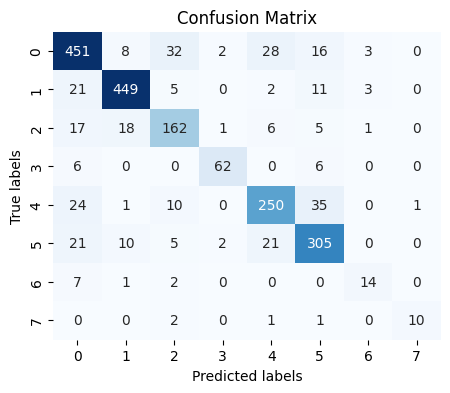

In [22]:
# cm, _, accuracy, micro_f1 = evaleate_model(model, tokenized_val_dataset, device)
cm, validation_report, accuracy = evaleate_model(model, trainer, tokenized_val_dataset, device)
print("Metrics for current model:")
print(f'Test accuracy: {accuracy:.4f}')
print(validation_report)
# print(f'Test F1 micro: {micro_f1:.4f}')
plot_confusion_matrix(cm, classes=range(len(classes_list)))